In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.transforms as mtransforms
import matplotlib.colors as mcolors
import seaborn as sns
import colorsys

from matplotlib_inline.backend_inline import set_matplotlib_formats
from matplotlib.ticker import PercentFormatter, MultipleLocator
from matplotlib.patches import Patch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, HPacker, AnchoredOffsetbox
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys
from pathlib import Path
import os

# Add the src directory to Python path
src_path = Path('../src').resolve()
sys.path.insert(0, str(src_path))

# Always change to the quantitative directory
notebook_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
quantitative_dir = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir
os.chdir(quantitative_dir)

# Now import and use the dataloader
from dataloader import load_paper_df
from dataloader import load_most_recent_df

In [2]:
model_df, agent_df, benchmark_df = load_paper_df()

Looking for DB files in: /Users/peterkirgis/Documents/hal-paper-analysis/quantitative/hal-frontend/preprocessed_traces
Found 11 database files:
  - swebench_verified_mini.db
  - scicode.db
  - colbench_frontend_design.db
  - corebench_hard.db
  - usaco.db
  - taubench_airline.db
  - assistantbench.db
  - online_mind2web.db
  - scienceagentbench.db
  - colbench_backend_programming.db
  - gaia.db

Loading database: swebench_verified_mini

Tables in swebench_verified_mini.db: ['parsed_results', 'preprocessed_traces', 'token_usage']
  - parsed_results: 27 rows, 47 columns
  - preprocessed_traces: 27 rows, 5 columns
  - token_usage: 28 rows, 12 columns

Loading database: scicode

Tables in scicode.db: ['parsed_results', 'preprocessed_traces', 'token_usage']
  - parsed_results: 22 rows, 47 columns
  - preprocessed_traces: 22 rows, 5 columns
  - token_usage: 22 rows, 12 columns

Loading database: colbench_frontend_design

Tables in colbench_frontend_design.db: ['parsed_results', 'preprocessed

In [9]:
# Exclude Online Mind2Web
model_df = model_df[model_df['benchmark_name'] != 'online_mind2web']

=== Using linear cost for Pareto computation ===
Saved plot: accuracy_vs_cost_total.png


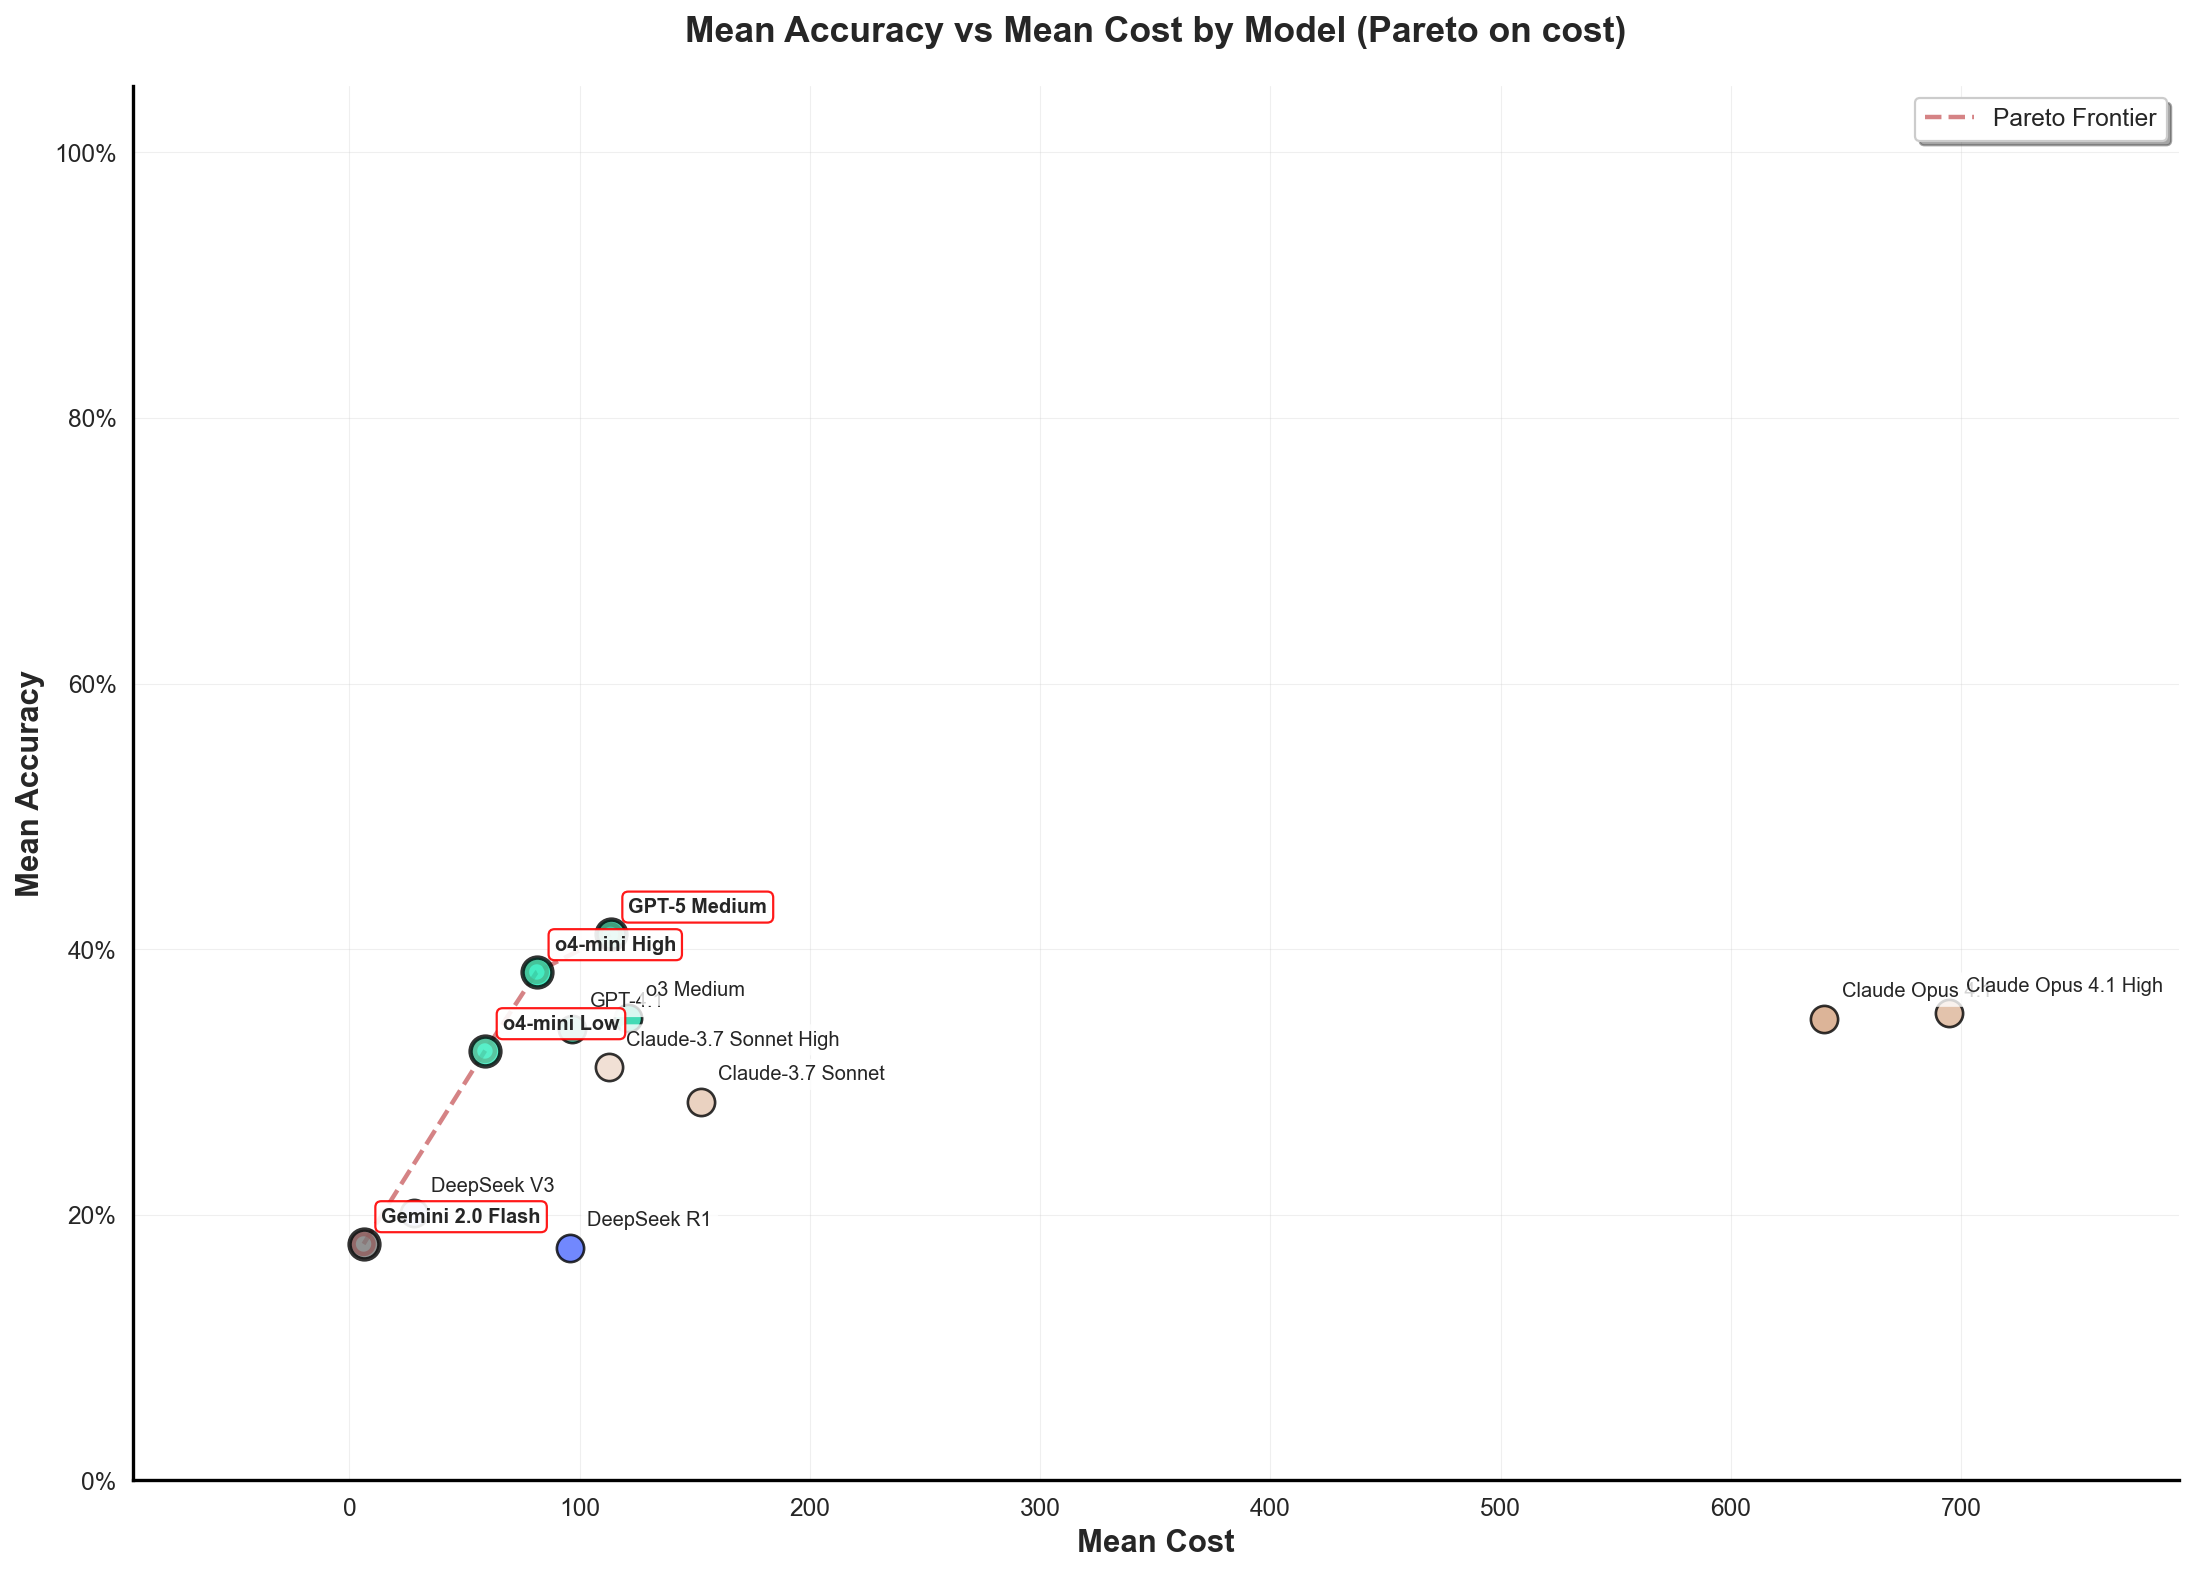


Pareto Optimal Models (computed using cost):
  - Gemini 2.0 Flash: 17.8% accuracy, 6.188 average cost
  - o4-mini Low: 32.3% accuracy, 58.902 average cost
  - o4-mini High: 38.3% accuracy, 81.426 average cost
  - GPT-5 Medium: 41.1% accuracy, 113.451 average cost

=== Using linear cost for Pareto computation with log x-axis (U-shaped frontier) ===
Saved plot: accuracy_vs_cost_total_logx_smooth.png


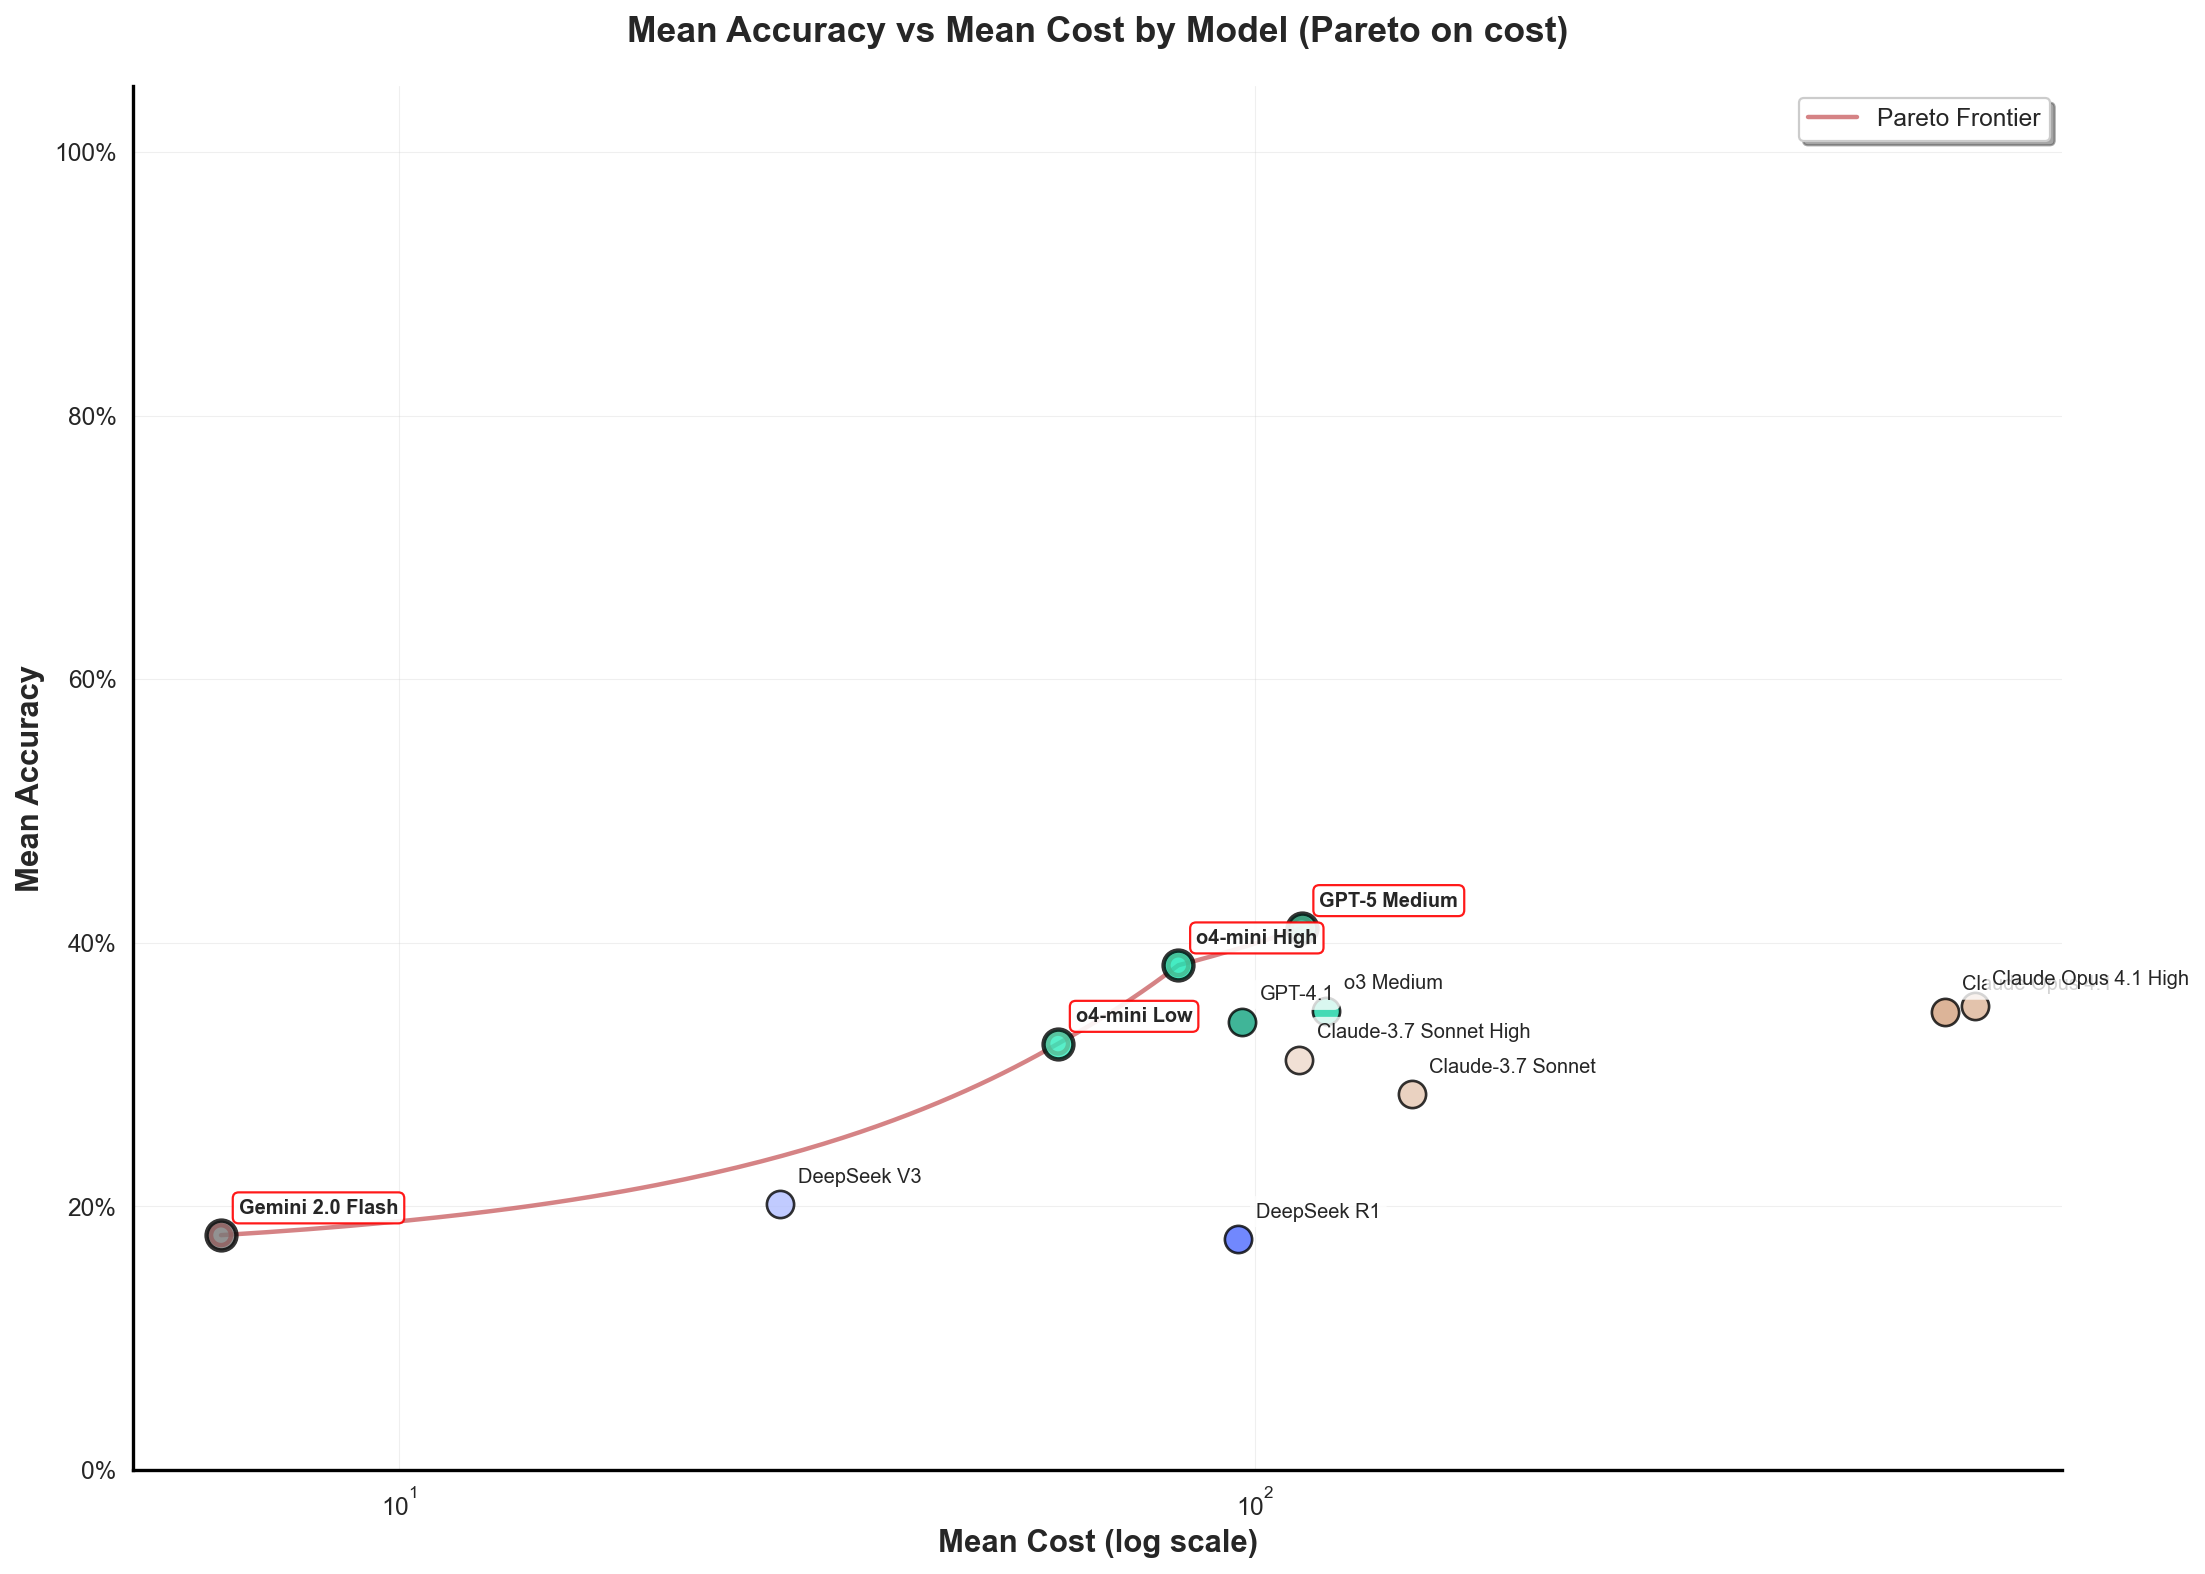


Pareto Optimal Models (computed using cost):
  - Gemini 2.0 Flash: 17.8% accuracy, 6.188 average cost
  - o4-mini Low: 32.3% accuracy, 58.902 average cost
  - o4-mini High: 38.3% accuracy, 81.426 average cost
  - GPT-5 Medium: 41.1% accuracy, 113.451 average cost

=== Using log-cost for Pareto computation with log x-axis ===
Saved plot: accuracy_vs_cost_total_logcost_logx.png


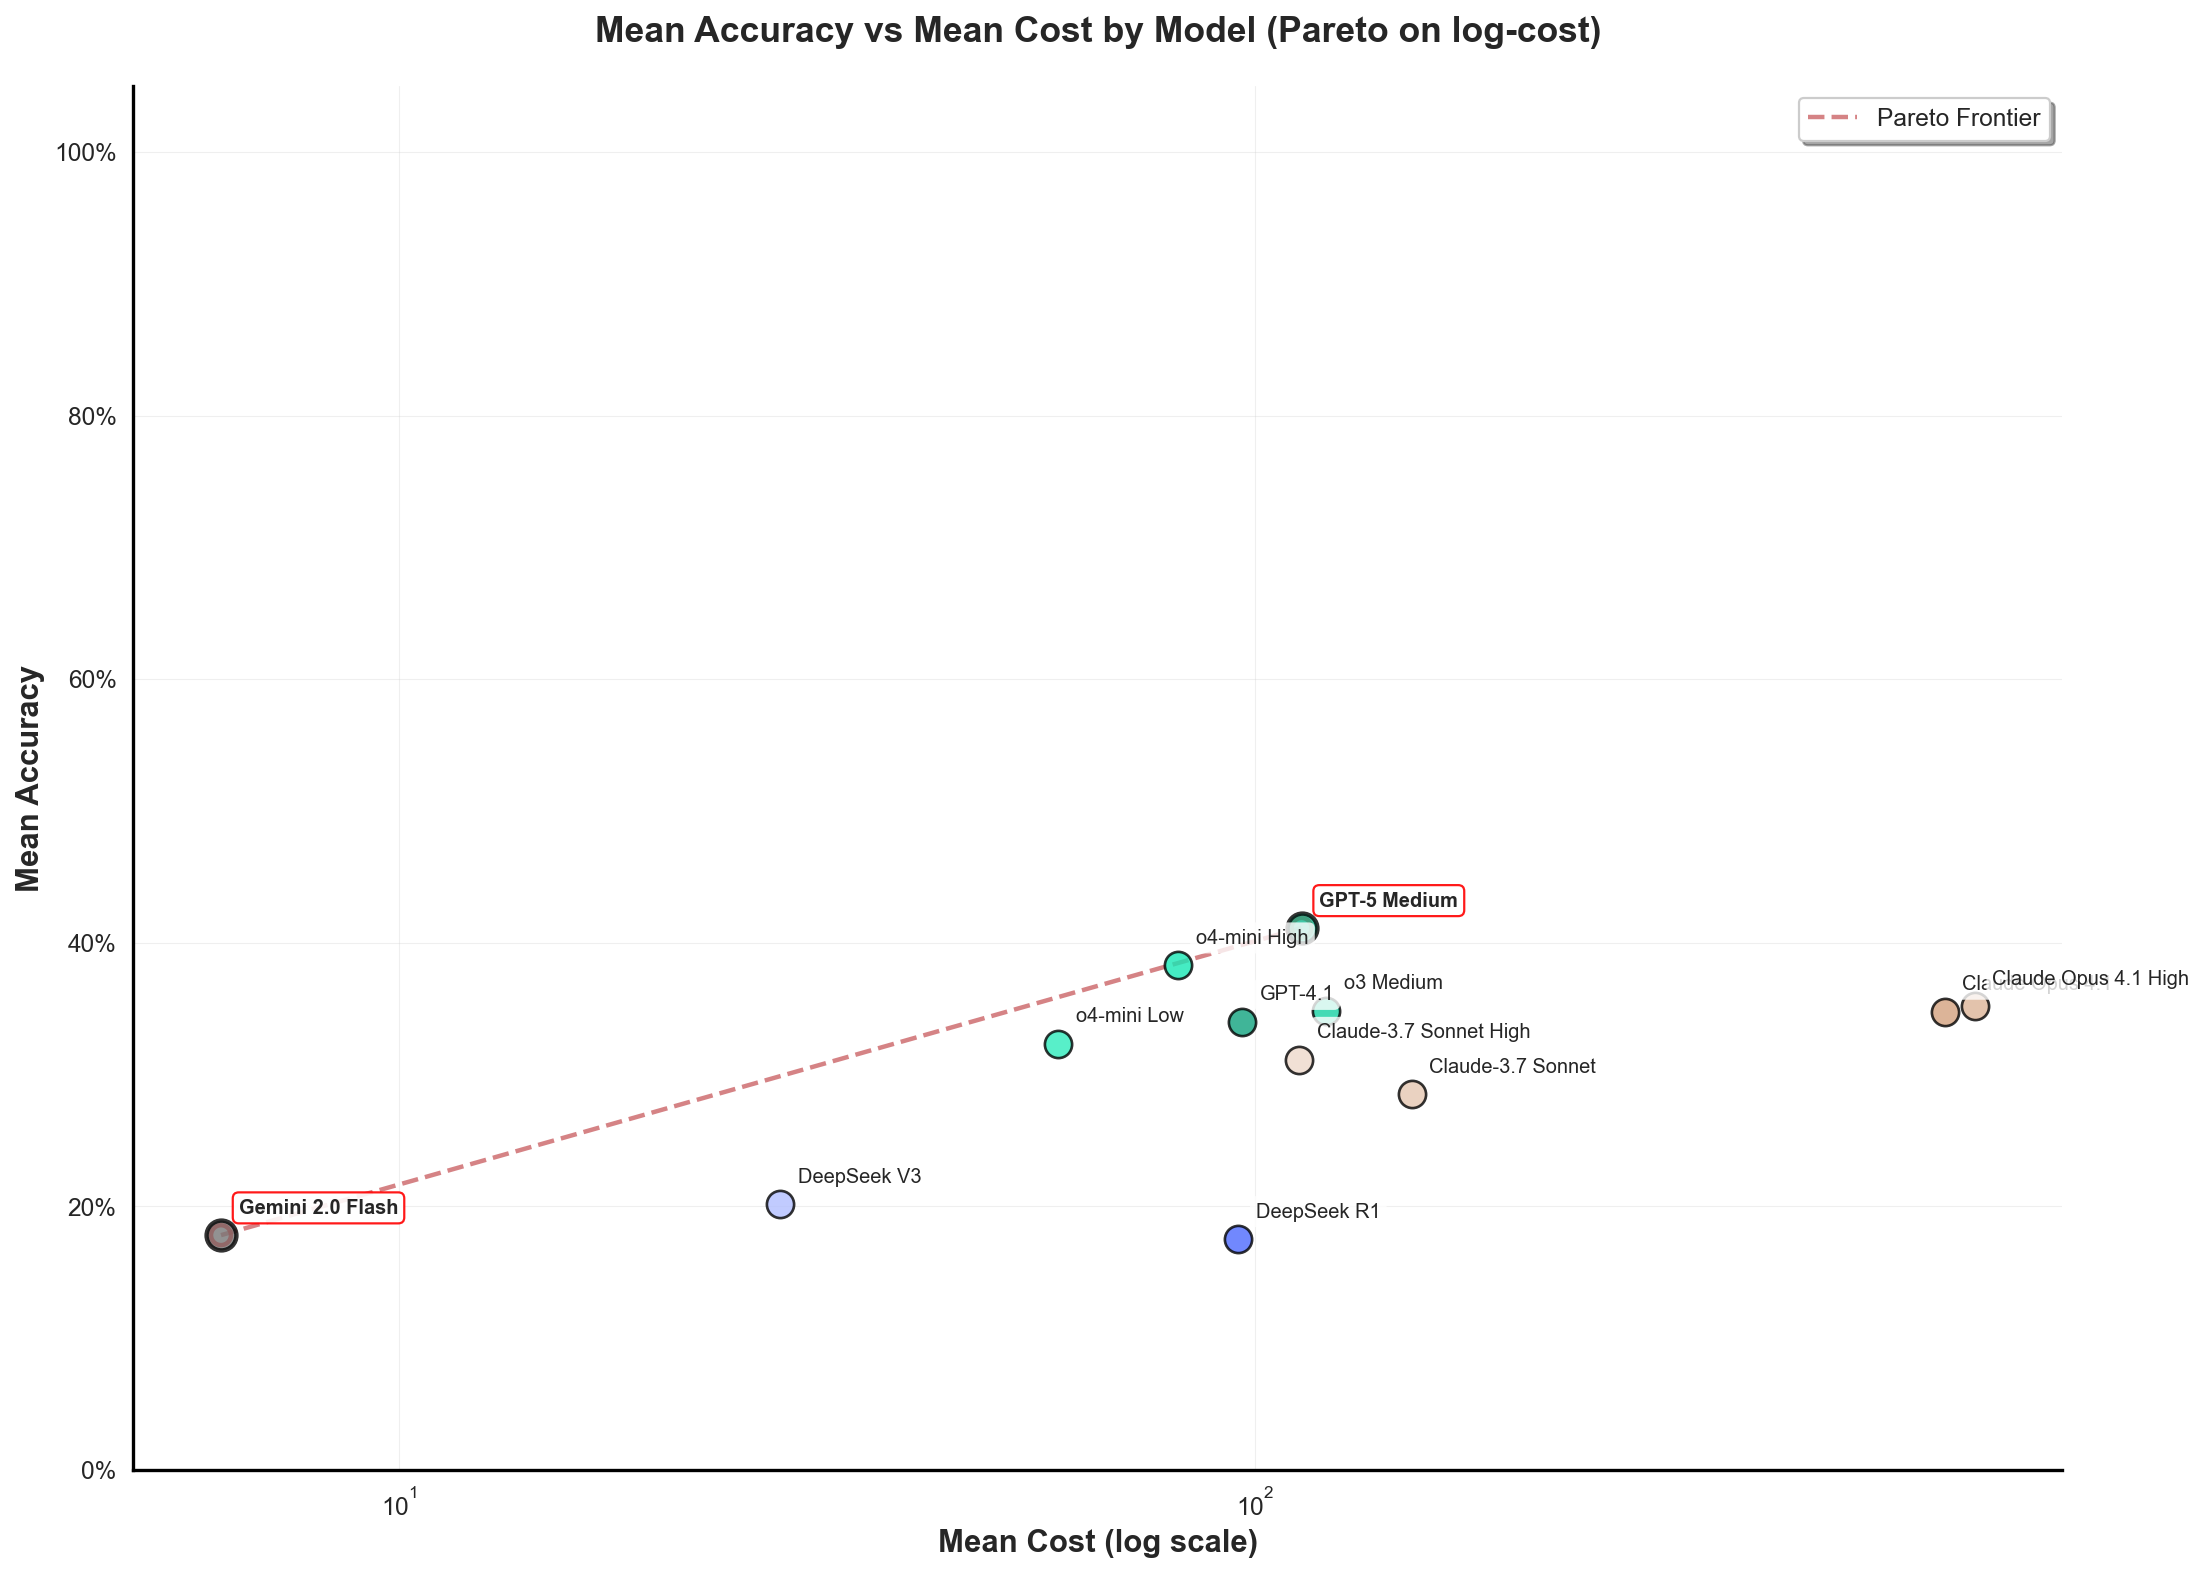


Pareto Optimal Models (computed using log-cost):
  - Gemini 2.0 Flash: 17.8% accuracy, 6.188 average cost
  - GPT-5 Medium: 41.1% accuracy, 113.451 average cost


In [ ]:
# ═══════════════════════════════════════════════════════════════════
# COLOR SCHEME AND STYLING (matching benchmark_bar_plots.ipynb)
# ═══════════════════════════════════════════════════════════════════

# Brand colors and model mappings (from benchmark_bar_plots.ipynb)
BRAND_BASE = { 
    "OpenAI": "#10A37F", 
    "Anthropic": "#D4A27F",
    "DeepSeek": "#4D6BFE"
}

COMP_OF = {
    "o3 Medium":"OpenAI","o4-mini High":"OpenAI","o4-mini Low":"OpenAI",
    "GPT-4.1":"OpenAI","GPT-5 Medium":"OpenAI",
    "o3-mini High":"OpenAI","o3-mini Low":"OpenAI",
    "GPT-OSS-120B High":"OpenAI","GPT-OSS-120B":"OpenAI",
    "Claude-3.7 Sonnet":"Anthropic","Claude-3.7 Sonnet High":"Anthropic",
    "Claude-4 Sonnet":"Anthropic", "Claude-4 Sonnet High":"Anthropic",
    "Claude-4.1 Opus":"Anthropic", "Claude-4.1 Opus High":"Anthropic",
    "Claude-4 Opus":"Anthropic", "Claude-4 Opus High":"Anthropic",
    "Claude Opus 4.1":"Anthropic", "Claude Opus 4.1 High":"Anthropic",
    "DeepSeek R1":"DeepSeek","DeepSeek V3":"DeepSeek",
    "Gemini 2.0 Flash":"Google",
}

def make_shades(base_hex, k, span=.20):
    """Create k shades of a base color."""
    r,g,b = mcolors.to_rgb(base_hex)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    hi    = min(1, l+span)
    return [mcolors.to_hex(colorsys.hls_to_rgb(h,L,s))
            for L in np.linspace(l,hi,k)]

def setup_colors(models):
    """Set up color scheme for models by company."""
    company_models, shade_of = {}, {}
    for m in models:
        company_models.setdefault(COMP_OF.get(m,"Other"), []).append(m)
    for comp, mlist in company_models.items():
        base = BRAND_BASE.get(comp, "#777777")
        for m,c in zip(sorted(mlist), make_shades(base, len(mlist))):
            shade_of[m] = c
    return shade_of

# Import the Pareto functions from the dataloader
from dataclasses import dataclass

@dataclass
class Agent:
    total_cost: float
    accuracy: float

def cross(point_o: Agent, point_a: Agent, point_b: Agent) -> int:
    return (point_a.total_cost - point_o.total_cost) * (point_b.accuracy - point_o.accuracy) - (point_a.accuracy - point_o.accuracy) * (point_b.total_cost - point_o.total_cost)

def compute_hull_side(points: list[Agent]) -> list[Agent]:
    hull: list[Agent] = []
    for p in points:
        while len(hull) >= 2 and cross(hull[-2], hull[-1], p) <= 0:
            hull.pop()
        hull.append(p)
    return hull

def is_pareto_efficient(others, candidate):
    for other in others:
        if (other.total_cost <= candidate.total_cost and other.accuracy >= candidate.accuracy) and \
           (other.total_cost < candidate.total_cost or other.accuracy > candidate.accuracy):
            return False
    return True

def compute_pareto_frontier(plot_df, use_log_cost=False):
    """
    Compute the Pareto frontier using upper convex hull approach.
    
    Args:
        plot_df: DataFrame with 'total_cost' and 'accuracy' columns
        use_log_cost: If True, use log(total_cost) for Pareto computation
        
    Returns:
        pareto_points: Array of [cost, accuracy] points on frontier
        pareto_indices: Indices of frontier points in original DataFrame
    """
    # Extract cost and accuracy arrays
    costs = plot_df['total_cost'].values
    accuracies = plot_df['accuracy'].values
    
    # Use log cost if specified
    if use_log_cost:
        # Guard against zeros/negatives (shouldn't happen, but just in case)
        costs_for_pareto = np.log(np.maximum(costs, 1e-12))
    else:
        costs_for_pareto = costs
    
    # Create Agent objects using the chosen cost metric
    agents = [Agent(total_cost=cost, accuracy=acc) for cost, acc in zip(costs_for_pareto, accuracies)]
    
    # Sort by cost, then by accuracy (for consistent ordering)
    sorted_agents = sorted(agents, key=lambda p: (p.total_cost, p.accuracy))
    
    if len(sorted_agents) <= 1:
        # Return original costs (not log-transformed) for plotting
        pareto_points = np.array([[cost, acc] for cost, acc in zip(costs, accuracies)])
        pareto_indices = list(range(len(sorted_agents)))
        return pareto_points, pareto_indices

    # Compute upper convex hull
    upper_convex_hull = compute_hull_side(list(reversed(sorted_agents)))
    
    # Filter to only Pareto efficient points
    pareto_agents = [agent for agent in upper_convex_hull if is_pareto_efficient(upper_convex_hull, agent)]
    
    # Find original indices by matching coordinates in the transformed space
    pareto_indices = []
    for agent in pareto_agents:
        for i, (cost_trans, acc) in enumerate(zip(costs_for_pareto, accuracies)):
            if abs(cost_trans - agent.total_cost) < 1e-10 and abs(acc - agent.accuracy) < 1e-10:
                pareto_indices.append(i)
                break
    
    # Return original costs (not log-transformed) for plotting
    pareto_points = np.array([[costs[i], accuracies[i]] for i in pareto_indices])
    
    # Sort points by original cost for proper line drawing
    if len(pareto_points) > 1:
        sorted_indices = np.argsort(pareto_points[:, 0])
        pareto_points = pareto_points[sorted_indices]
        pareto_indices = [pareto_indices[i] for i in sorted_indices]
    
    return pareto_points, pareto_indices

def create_smooth_pareto_line(pareto_points, n_points=100):
    """
    Create a smooth interpolated line between Pareto points.
    This creates more points for smoother U-shaped curves on log scales.
    """
    if len(pareto_points) < 2:
        return pareto_points
    
    # Sort by cost
    sorted_points = pareto_points[np.argsort(pareto_points[:, 0])]
    
    # Create interpolated points between consecutive Pareto points
    smooth_x = []
    smooth_y = []
    
    for i in range(len(sorted_points) - 1):
        x1, y1 = sorted_points[i]
        x2, y2 = sorted_points[i + 1]
        
        # Create linearly spaced points between these two points
        segment_x = np.linspace(x1, x2, n_points // (len(sorted_points) - 1))
        segment_y = np.linspace(y1, y2, n_points // (len(sorted_points) - 1))
        
        smooth_x.extend(segment_x)
        smooth_y.extend(segment_y)
    
    return np.column_stack([smooth_x, smooth_y])

# Updated plot function with Pareto frontier and cost scale options
def plot_accuracy_vs_cost(df, save_plots=False, use_log_cost_for_pareto=False, use_log_x_axis=False, smooth_pareto_line=False):
    """
    Plot accuracy vs cost with Pareto frontier.
    
    Args:
        df: DataFrame with model data
        save_plots: Whether to save the plot
        use_log_cost_for_pareto: Whether to use log(cost) for Pareto computation
        use_log_x_axis: Whether to use log scale for x-axis display
        smooth_pareto_line: Whether to create smooth interpolated Pareto line
    """
    plt.close('all')
    
    # Set up the plot style matching benchmark_bar_plots
    mpl.rcParams.update({
        "figure.dpi": 160,
        "savefig.dpi": 300,
        "font.size": 10,
        "font.family": "Inter",
        "font.weight": 400,
        "hatch.linewidth": .8,
    })
    sns.set_theme(style="white", rc={"axes.grid": False})

    plot_df = df.groupby('model').agg(
        total_cost=('total_cost', 'mean'),
        accuracy=('accuracy', 'mean')
    ).reset_index()
    
    # Set up colors for models using the same system as benchmark_bar_plots
    models = plot_df['model'].tolist()
    shade_of = setup_colors(models)
    
    # Compute Pareto frontier (can use log cost for computation while plotting original cost)
    pareto_points, pareto_indices = compute_pareto_frontier(plot_df, use_log_cost=use_log_cost_for_pareto)
    
    # Create figure and axis with better proportions
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot Pareto frontier first (so it appears behind points)
    if len(pareto_points) > 1:
        if smooth_pareto_line:
            # Create smooth line with many interpolated points
            smooth_points = create_smooth_pareto_line(pareto_points, n_points=200)
            ax.plot(smooth_points[:, 0], smooth_points[:, 1], 
                   'r-', linewidth=2, alpha=0.7, zorder=2,
                   label='Pareto Frontier')
        else:
            # Standard straight-line connections
            ax.plot(pareto_points[:, 0], pareto_points[:, 1], 
                   'r--', linewidth=2, alpha=0.7, zorder=2,
                   label='Pareto Frontier')
        
        # Optionally add markers for Pareto optimal points
        ax.scatter(pareto_points[:, 0], pareto_points[:, 1],
                  s=80, facecolors='none', edgecolors='red', 
                  linewidth=2, alpha=0.8, zorder=2)
    
    # Create scatter plot with company colors and add labels
    for i, model in enumerate(models):
        model_data = plot_df[plot_df['model'] == model]
        x = model_data['total_cost'].iloc[0]
        y = model_data['accuracy'].iloc[0]
        
        # Check if this point is on the Pareto frontier
        is_pareto = i in pareto_indices
        point_size = 180 if is_pareto else 150
        edge_width = 2.0 if is_pareto else 1.2
        
        # Plot the point
        ax.scatter(
            x, y,
            color=shade_of[model],
            s=point_size,
            edgecolor='black',
            linewidth=edge_width,
            alpha=0.8,
            zorder=3
        )
        
        # Add text label for the point
        ax.annotate(
            model,
            (x, y),
            xytext=(8, 8),  # Offset the text slightly from the point
            textcoords='offset points',
            fontsize=9,
            fontweight='bold' if is_pareto else 'normal',
            ha='left',
            va='bottom',
            bbox=dict(boxstyle='round,pad=0.3', 
                     facecolor='white', alpha=0.9 if is_pareto else 0.8, 
                     edgecolor='red' if is_pareto else 'none',
                     linewidth=1 if is_pareto else 0),
            zorder=4
        )
    
    # Style the axes to match benchmark_bar_plots
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    for spine in ('left', 'bottom'):
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_linewidth(1.5)
        ax.spines[spine].set_color('black')
    
    ax.tick_params(axis='both', which='major', color='black', width=1, length=4)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=1)
    
    # Set x-axis scale
    if use_log_x_axis:
        ax.set_xscale('log')
        x_label = 'Mean Cost (log scale)'
        x_margin_factor = 0.05  # Relative margin for log scale
        x_min, x_max = plot_df['total_cost'].min(), plot_df['total_cost'].max()
        x_range = x_max / x_min
        ax.set_xlim(x_min / (x_range**x_margin_factor), x_max * (x_range**x_margin_factor))
    else:
        x_label = 'Mean Cost'
        x_margin = 100  # Absolute margin for linear scale
        ax.set_xlim(plot_df['total_cost'].min() - x_margin, plot_df['total_cost'].max() + x_margin)
    
    # Set labels and title with improved formatting
    ax.set_xlabel(x_label, fontsize=14, fontweight='bold')
    ax.set_ylabel('Mean Accuracy', fontsize=14, fontweight='bold')
    
    # Update title based on options
    pareto_method = "log-cost" if use_log_cost_for_pareto else "cost"
    title = f'Mean Accuracy vs Mean Cost by Model (Pareto on {pareto_method})'
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    # Set y-axis to percentage format
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    # Set y-axis limits
    y_margin = 0.05
    ax.set_ylim(plot_df['accuracy'].min() - y_margin, plot_df['accuracy'].max() + y_margin)
    
    # Add legend for Pareto frontier
    if len(pareto_points) > 1:
        ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout()
    
    # Save plot if requested
    if save_plots:
        output_path = str(quantitative_dir / "plots/")
        suffix = "_logcost" if use_log_cost_for_pareto else ""
        suffix += "_logx" if use_log_x_axis else ""
        suffix += "_smooth" if smooth_pareto_line else ""
        output_filename = f"accuracy_vs_cost_total{suffix}.png"
        fig.savefig(os.path.join(output_path, output_filename), bbox_inches='tight', dpi=300)
        print(f"Saved plot: {output_filename}")
    
    # Show plot
    plt.show()
    
    # Print Pareto optimal models
    if len(pareto_indices) > 0:
        print(f"\nPareto Optimal Models (computed using {'log-cost' if use_log_cost_for_pareto else 'cost'}):")
        pareto_models = plot_df.iloc[pareto_indices]
        for _, row in pareto_models.iterrows():
            print(f"  - {row['model']}: {row['accuracy']:.1%} accuracy, {row['total_cost']:.3f} average cost")

# Example usage - try different combinations:
print("=== Using linear cost for Pareto computation ===")
plot_accuracy_vs_cost(model_df, save_plots=True, use_log_cost_for_pareto=False, use_log_x_axis=False)

print("\n=== Using linear cost for Pareto computation with log x-axis (U-shaped frontier) ===")
plot_accuracy_vs_cost(model_df, save_plots=True, use_log_cost_for_pareto=False, use_log_x_axis=True, smooth_pareto_line=True)

print("\n=== Using log-cost for Pareto computation with log x-axis ===")
plot_accuracy_vs_cost(model_df, save_plots=True, use_log_cost_for_pareto=True, use_log_x_axis=True)

Saved plot: accuracy_vs_cost_by_benchmark.png


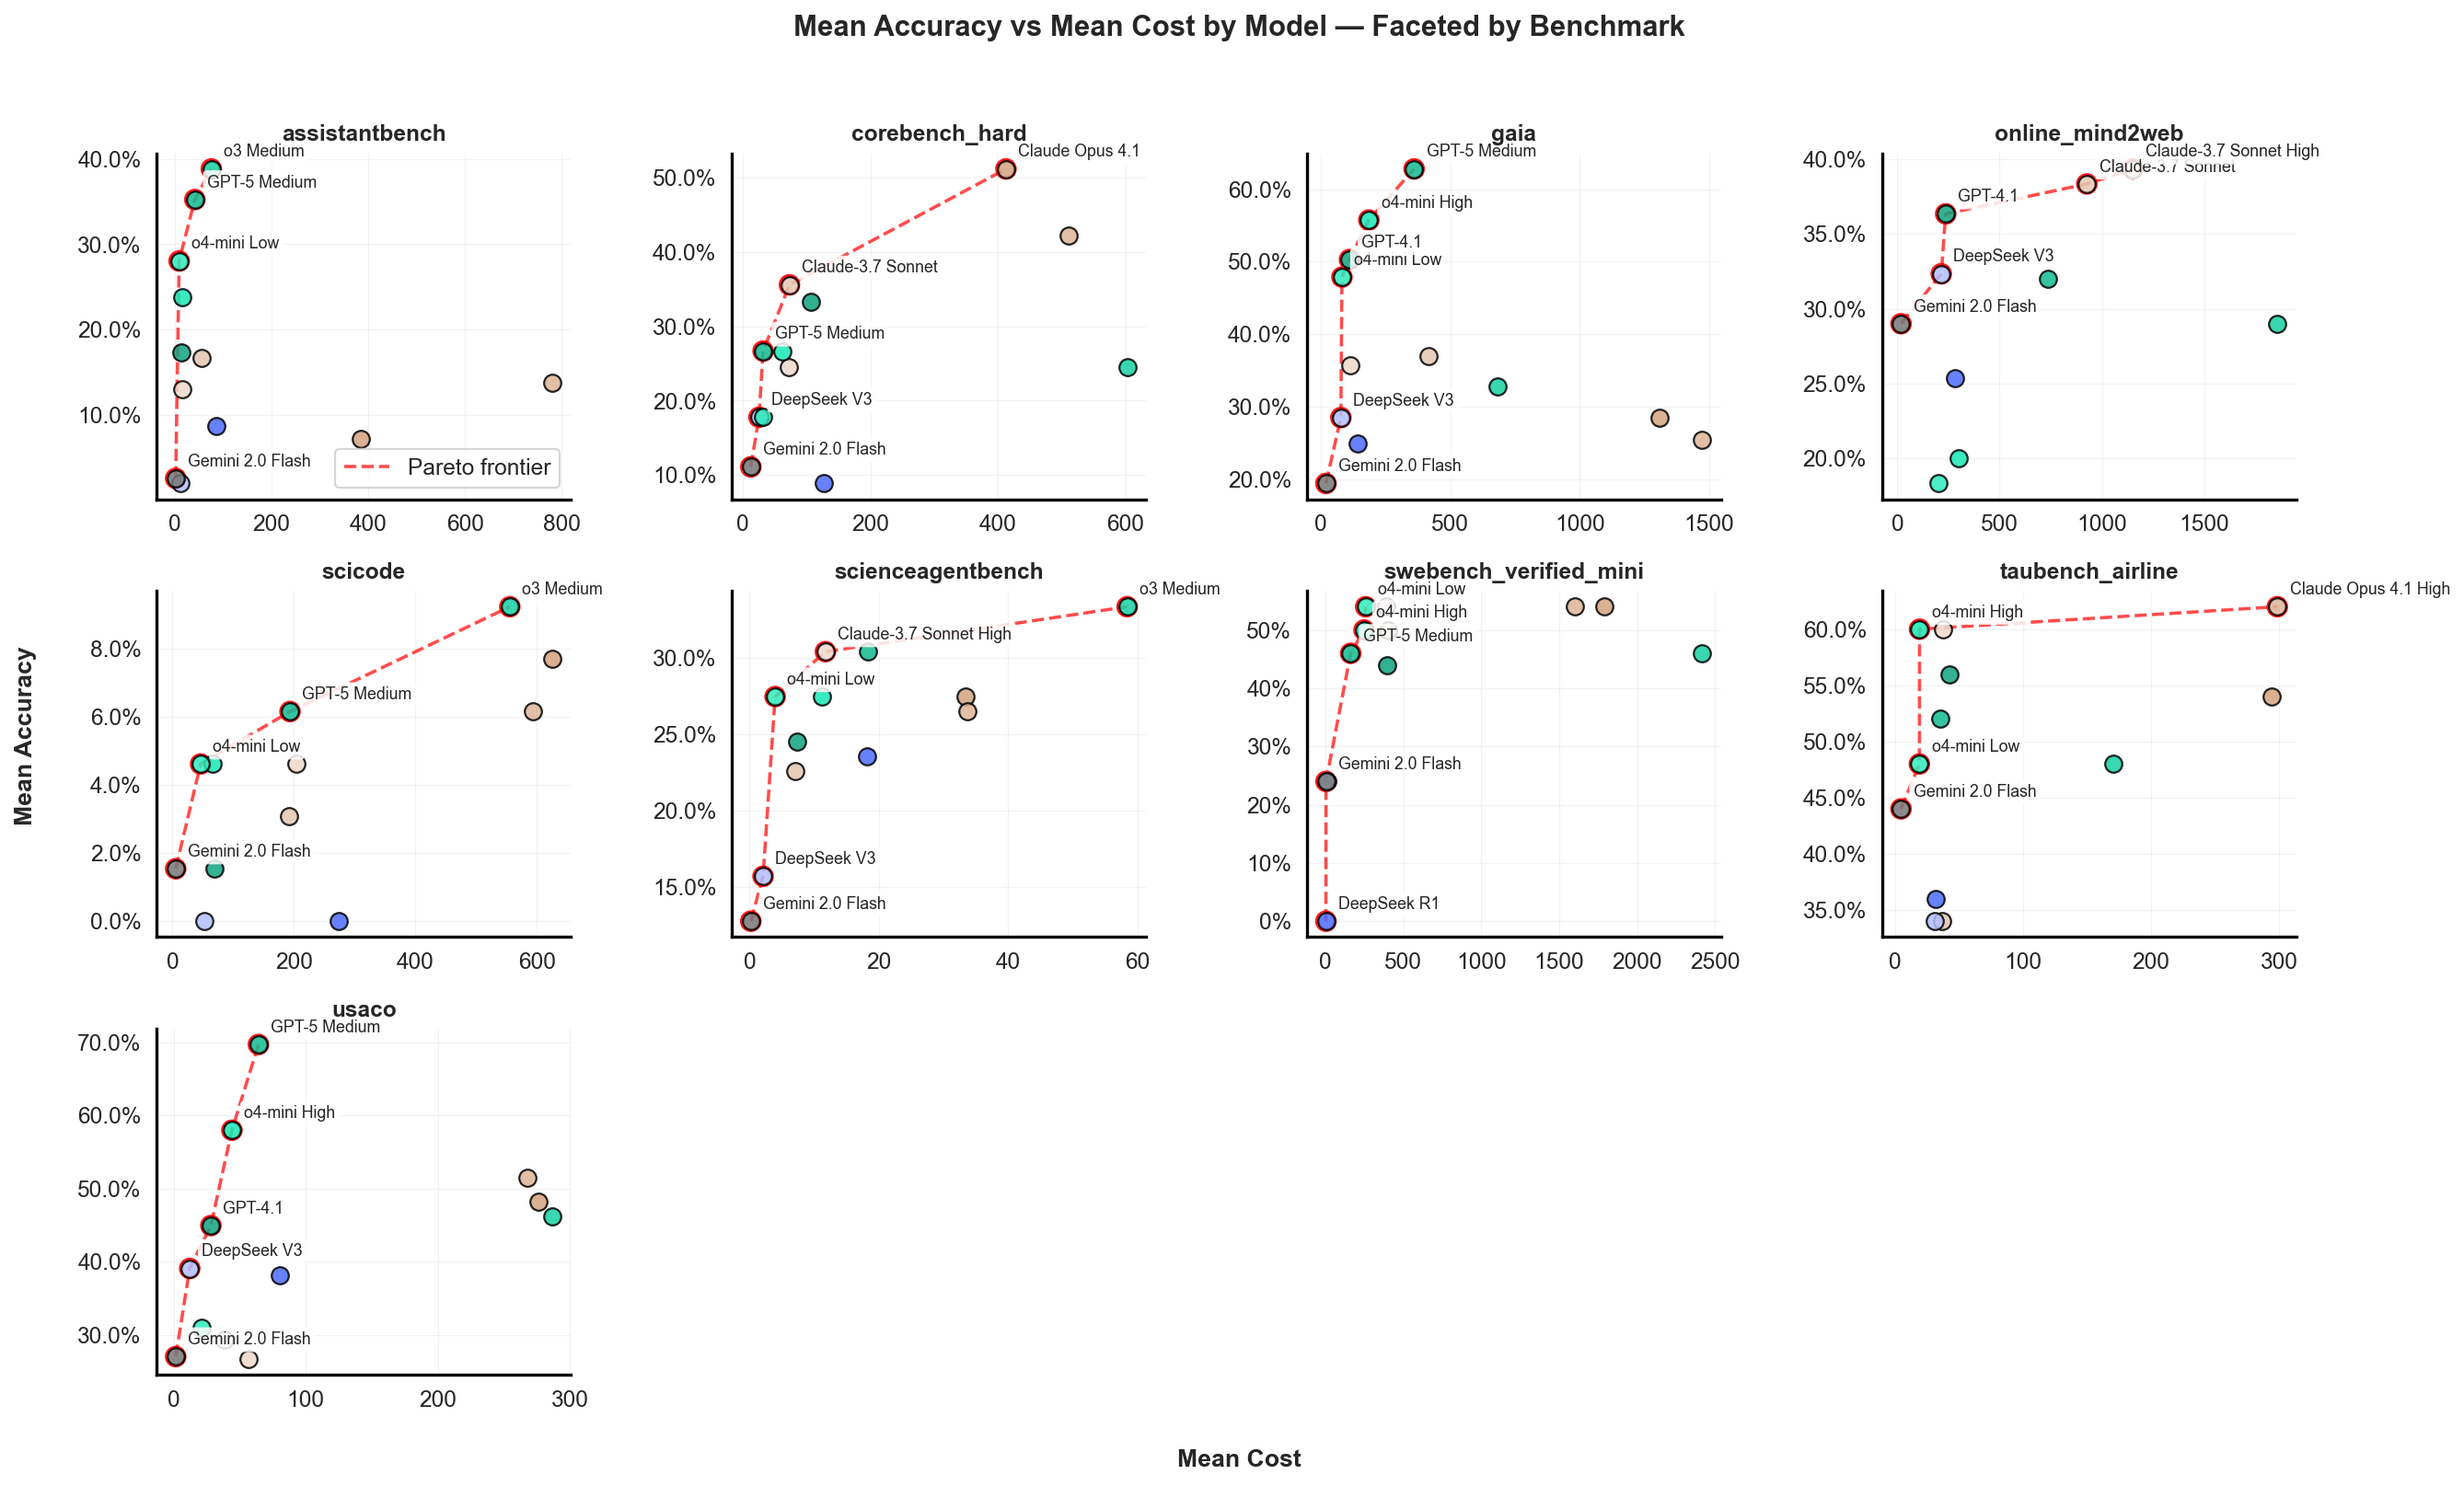


Pareto Optimal Models (by benchmark):
  assistantbench: Gemini 2.0 Flash (2.6%, 2.178), o4-mini Low (28.0%, 9.216), GPT-5 Medium (35.2%, 41.692), o3 Medium (38.8%, 75.767)
  corebench_hard: Gemini 2.0 Flash (11.1%, 12.461), DeepSeek V3 (17.8%, 25.259), GPT-5 Medium (26.7%, 31.760), Claude-3.7 Sonnet (35.6%, 73.040), Claude Opus 4.1 (51.1%, 412.415)
  gaia: Gemini 2.0 Flash (19.4%, 18.817), DeepSeek V3 (28.5%, 76.639), o4-mini Low (47.9%, 80.800), GPT-4.1 (50.3%, 109.877), o4-mini High (55.8%, 184.866), GPT-5 Medium (62.8%, 359.825)
  online_mind2web: Gemini 2.0 Flash (29.0%, 18.015), DeepSeek V3 (32.3%, 214.744), GPT-4.1 (36.3%, 236.620), Claude-3.7 Sonnet (38.3%, 926.481), Claude-3.7 Sonnet High (39.3%, 1151.879)
  scicode: Gemini 2.0 Flash (1.5%, 5.229), o4-mini Low (4.6%, 46.303), GPT-5 Medium (6.2%, 193.523), o3 Medium (9.2%, 555.571)
  scienceagentbench: Gemini 2.0 Flash (12.7%, 0.193), DeepSeek V3 (15.7%, 2.090), o4-mini Low (27.5%, 3.954), Claude-3.7 Sonnet High (30.4%, 11.742)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import PercentFormatter
import seaborn as sns

def _pareto_indices(costs, accs):
    """
    Return index array of points on the Pareto frontier where
    lower cost is better and higher accuracy is better.
    Assumes 1D arrays costs, accs of equal length.
    """
    order = np.argsort(costs)                      # sort by increasing cost
    acc_sorted = accs[order]
    keep = []
    best = -np.inf
    for i, a in zip(order, acc_sorted):
        if a > best:
            keep.append(i)
            best = a
    return np.array(keep, dtype=int)

def plot_accuracy_vs_cost_by_benchmark(df, save_plots=False, annotate='pareto', log_x=False, col_wrap=4):
    """
    Faceted Accuracy vs Cost plot, one panel per benchmark, with Pareto frontier per facet.
      - annotate: 'pareto' | 'none' | 'all'
      - log_x: log-scale the x-axis (cost)
      - col_wrap: number of panels per row
    Expects columns: benchmark_name, model, total_cost, accuracy
    """
    plt.close('all')
    # Style (matching your bar plots)
    mpl.rcParams.update({
        "figure.dpi": 160,
        "savefig.dpi": 300,
        "font.size": 10,
        "font.family": "Inter",
        "font.weight": 400,
        "hatch.linewidth": .8,
    })
    sns.set_theme(style="white", rc={"axes.grid": False})

    # Aggregate to model × benchmark means
    plot_df = (
        df.dropna(subset=["benchmark_name","model","total_cost","accuracy"])
          .groupby(["benchmark_name","model"], as_index=False)
          .agg(total_cost=("total_cost","mean"),
               accuracy=("accuracy","mean"))
    )

    if plot_df.empty:
        print("No data to plot.")
        return

    # Consistent colors across all facets
    models = plot_df['model'].unique().tolist()
    shade_of = setup_colors(models)

    # Compute global axis limits for consistent comparison
    x_min, x_max = plot_df['total_cost'].min(), plot_df['total_cost'].max()
    y_min, y_max = plot_df['accuracy'].min(), plot_df['accuracy'].max()
    x_pad = (x_max - x_min) * 0.06 if x_max > x_min else 1.0
    y_pad = (y_max - y_min) * 0.06 if y_max > y_min else 0.02

    # Facet set-up
    bench_list = sorted(plot_df['benchmark_name'].unique())
    n = len(bench_list)
    ncols = min(col_wrap, n)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.2*ncols, 3.4*nrows), squeeze=False)

    for idx, bench in enumerate(bench_list):
        r, c = divmod(idx, ncols)
        ax = axes[r, c]

        sub = plot_df[plot_df['benchmark_name'] == bench].copy()
        costs = sub['total_cost'].to_numpy()
        accs  = sub['accuracy'].to_numpy()

        # Pareto frontier
        p_idx = _pareto_indices(costs, accs)
        pareto = sub.iloc[p_idx].sort_values('total_cost')

        # frontier line & halo markers
        if len(pareto) >= 2:
            ax.plot(pareto['total_cost'], pareto['accuracy'],
                    linestyle='--', linewidth=1.6, color='red', alpha=0.7,
                    label='Pareto frontier', zorder=2)
        ax.scatter(pareto['total_cost'], pareto['accuracy'],
                   s=80, facecolors='none', edgecolors='red',
                   linewidth=1.6, alpha=0.9, zorder=3)

        # all points
        for _, row in sub.iterrows():
            ax.scatter(row['total_cost'], row['accuracy'],
                       s=70, color=shade_of.get(row['model'], "#777777"),
                       edgecolor='black', linewidth=1.0, alpha=0.85, zorder=3)

        # annotations
        if annotate in ('all','pareto'):
            to_annotate = pareto if annotate == 'pareto' else sub
            for _, row in to_annotate.iterrows():
                ax.annotate(row['model'],
                            (row['total_cost'], row['accuracy']),
                            xytext=(6, 6), textcoords='offset points',
                            fontsize=8,
                            bbox=dict(boxstyle='round,pad=0.25',
                                      facecolor='white', alpha=0.85,
                                      edgecolor='none'))

        # axes formatting
        sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
        for spine in ('left','bottom'):
            ax.spines[spine].set_visible(True)
            ax.spines[spine].set_linewidth(1.5)
            ax.spines[spine].set_color('black')
        ax.tick_params(axis='both', which='major', color='black', width=1, length=4)
        ax.grid(True, alpha=0.25, linestyle='-', linewidth=0.5, zorder=1)

        if log_x:
            ax.set_xscale('log')

        # ax.set_xlim(x_min - x_pad, x_max + x_pad)
        # ax.set_ylim(y_min - y_pad, y_max + y_pad)
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        ax.set_title(bench, fontsize=11, fontweight='bold')

        # light legend per first panel only
        if idx == 0 and len(pareto) >= 2:
            ax.legend(loc='lower right', frameon=True, fancybox=True, shadow=False)

    # Hide any unused axes
    for j in range(n, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis('off')

    # Global labels
    fig.suptitle('Mean Accuracy vs Mean Cost by Model — Faceted by Benchmark', fontsize=14, fontweight='bold', y=0.98)
    fig.supxlabel('Mean Cost', fontsize=12, fontweight='bold')
    fig.supylabel('Mean Accuracy', fontsize=12, fontweight='bold', x=0.005)
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    if save_plots:
        output_path = str(quantitative_dir / "plots/")
        fname = "accuracy_vs_cost_by_benchmark.png"
        fig.savefig(os.path.join(output_path, fname), bbox_inches='tight', dpi=300)
        print(f"Saved plot: {fname}")

    plt.show()

    # Text summary of Pareto models per benchmark
    print("\nPareto Optimal Models (by benchmark):")
    for bench in bench_list:
        sub = plot_df[plot_df['benchmark_name'] == bench]
        if sub.empty: 
            continue
        p_idx = _pareto_indices(sub['total_cost'].to_numpy(), sub['accuracy'].to_numpy())
        pm = sub.iloc[p_idx].sort_values('total_cost')
        models_str = ", ".join(f"{m} ({a:.1%}, {c:.3f})" for m,a,c in zip(pm['model'], pm['accuracy'], pm['total_cost']))
        print(f"  {bench}: {models_str}")

plot_accuracy_vs_cost_by_benchmark(filtered_df, save_plots=True, annotate='pareto', log_x=False, col_wrap=4)

Creating accuracy vs token usage plot by benchmark...


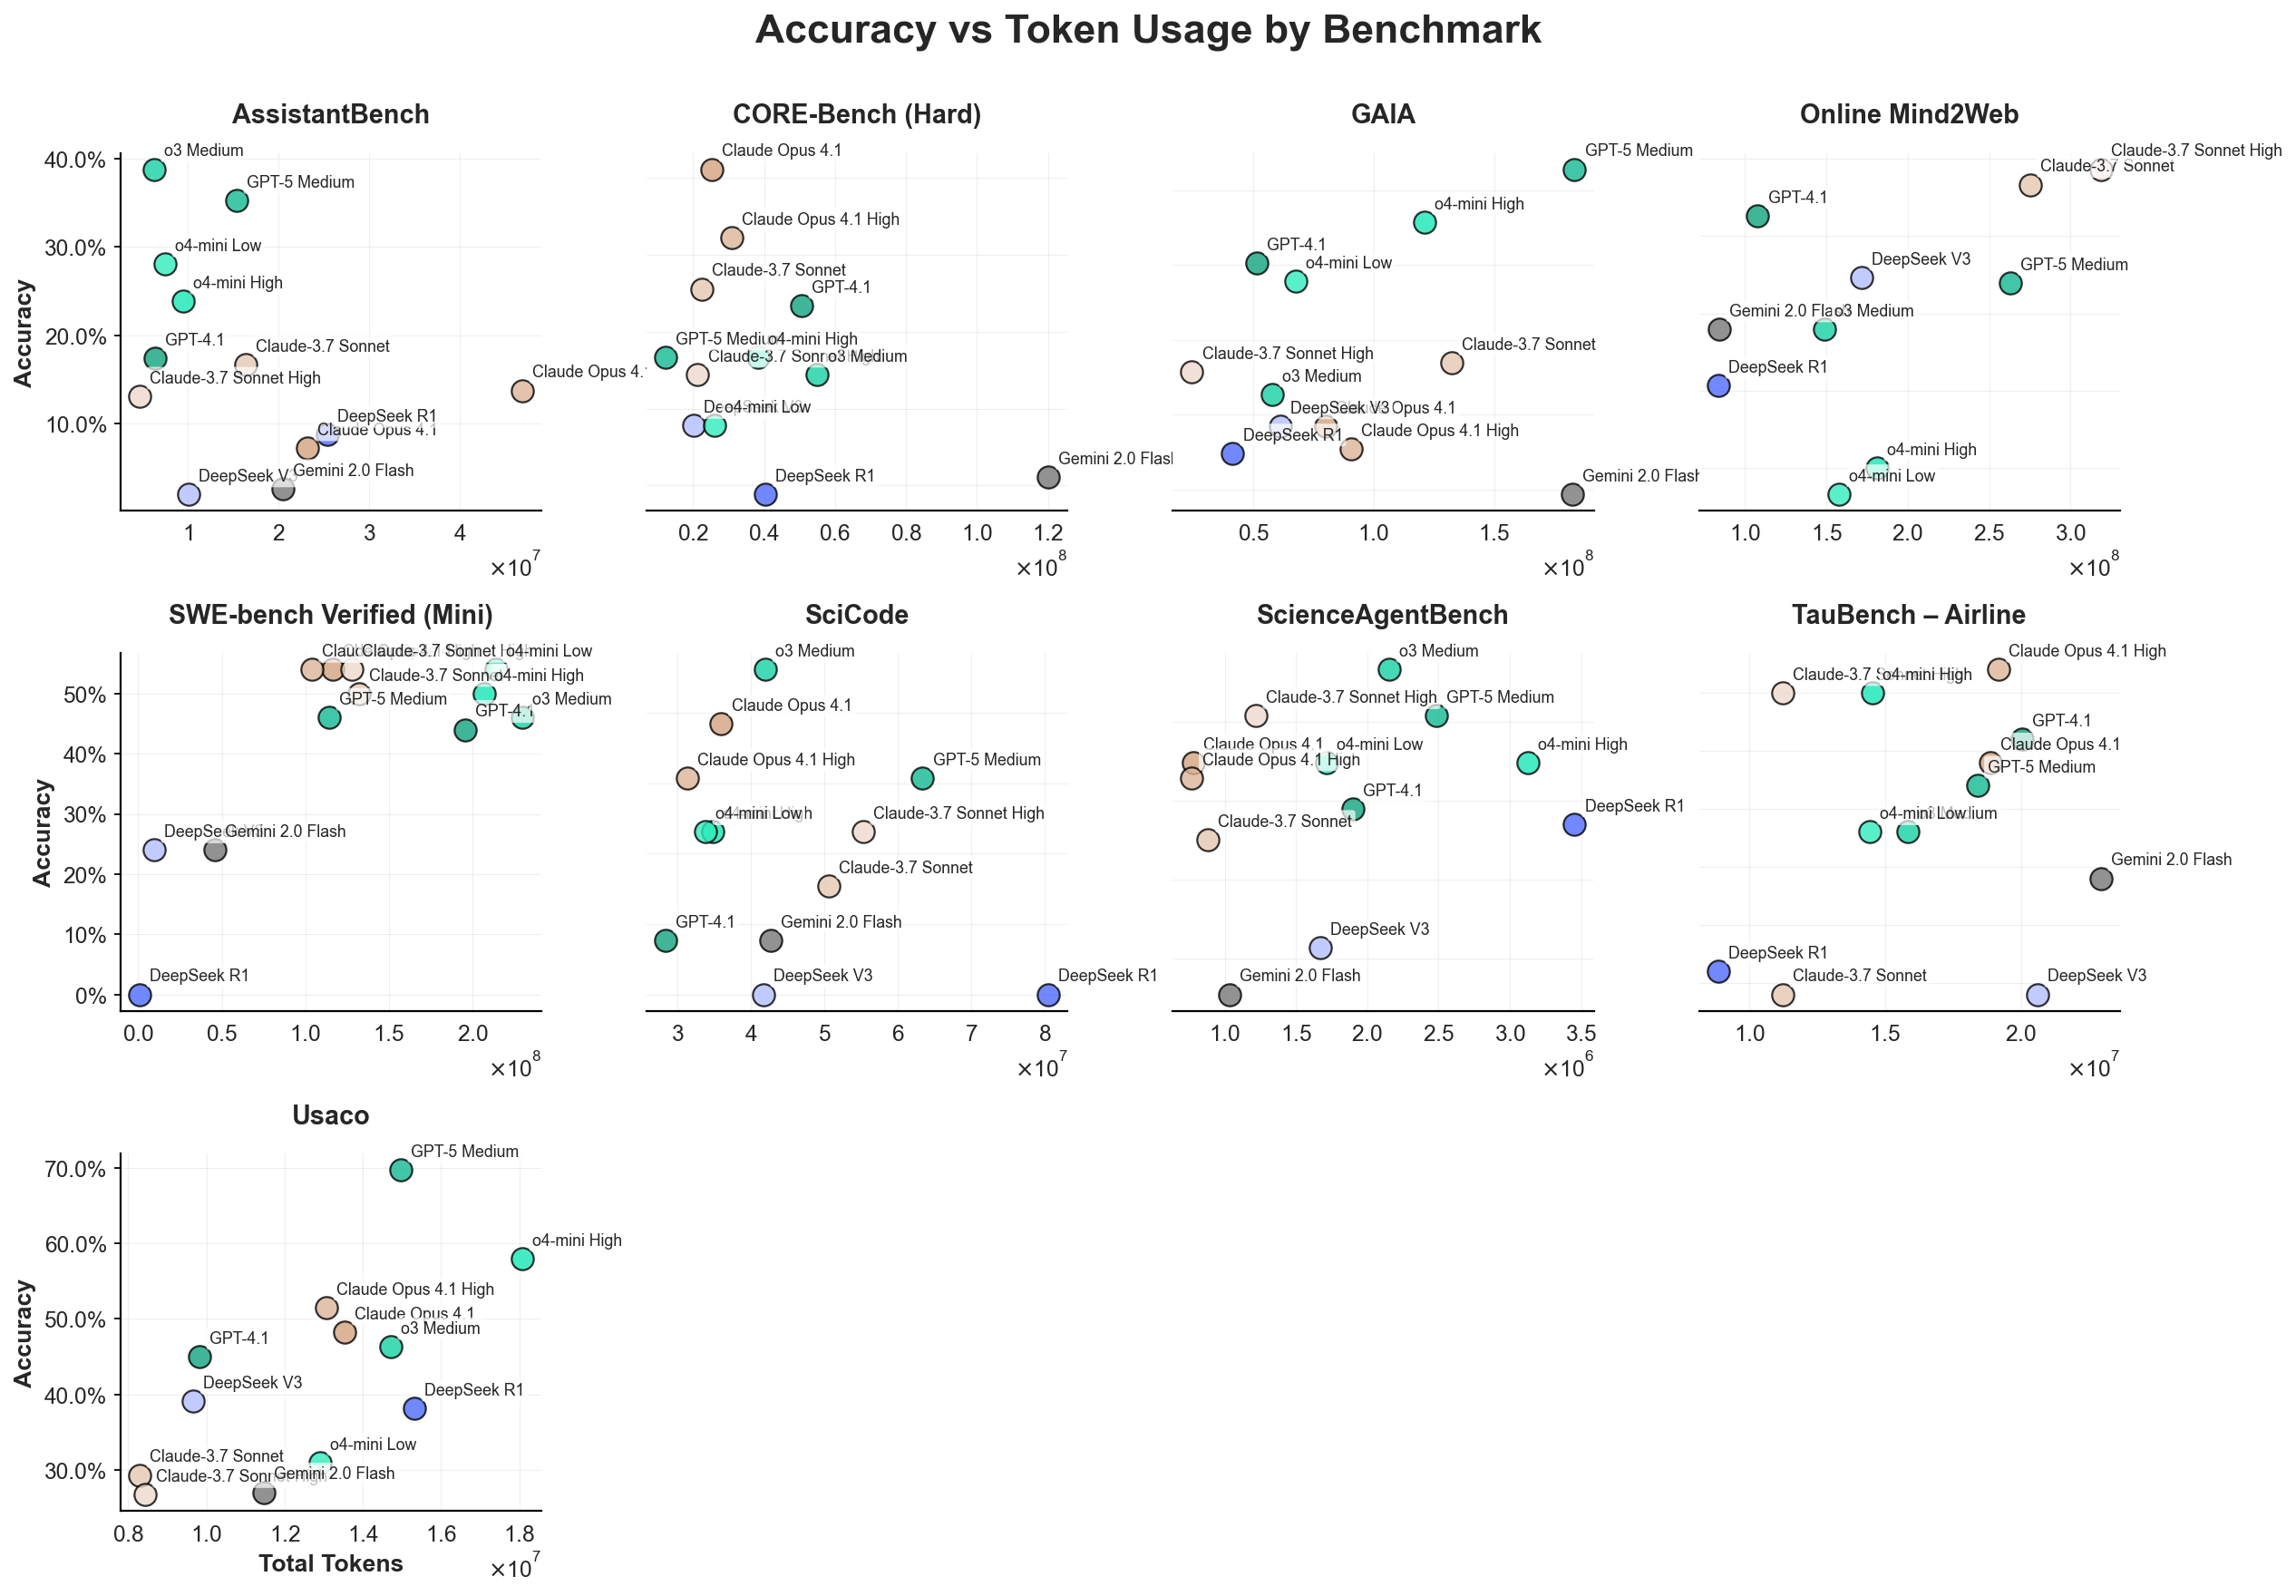

Saved plot: accuracy_vs_tokens_by_benchmark.png

Token Usage Summary by Benchmark:

AssistantBench:
  Models: 12
  Avg Tokens: 16,046,355
  Token Range: 4,752,848 - 46,870,341
  Avg Accuracy: 17.3%

CORE-Bench (Hard):
  Models: 12
  Avg Tokens: 38,595,033
  Token Range: 12,338,711 - 120,140,252
  Avg Accuracy: 26.7%

GAIA:
  Models: 12
  Avg Tokens: 91,185,709
  Token Range: 24,535,694 - 183,453,868
  Avg Accuracy: 37.4%

Online Mind2Web:
  Models: 10
  Avg Tokens: 179,197,521
  Token Range: 83,509,536 - 318,593,019
  Avg Accuracy: 30.0%

SWE-bench Verified (Mini):
  Models: 12
  Avg Tokens: 124,708,838
  Token Range: 853,388 - 229,847,128
  Avg Accuracy: 41.7%

SciCode:
  Models: 12
  Avg Tokens: 45,014,927
  Token Range: 28,400,800 - 80,465,132
  Avg Accuracy: 4.1%

ScienceAgentBench:
  Models: 12
  Avg Tokens: 1,765,204
  Token Range: 769,666 - 3,454,246
  Avg Accuracy: 25.2%

TauBench – Airline:
  Models: 12
  Avg Tokens: 16,347,424
  Token Range: 8,850,934 - 22,938,254
  Avg Accur

In [6]:
# ═══════════════════════════════════════════════════════════════════
# ACCURACY VS TOKEN USAGE FACETED BY BENCHMARK
# ═══════════════════════════════════════════════════════════════════

def plot_accuracy_vs_tokens_by_benchmark(df, save_plots=False):
    """Create faceted scatter plots of accuracy vs token usage by benchmark."""
    plt.close('all')
    
    # Set up the plot style matching benchmark_bar_plots
    mpl.rcParams.update({
        "figure.dpi": 160,
        "savefig.dpi": 300,
        "font.size": 12,
        "hatch.linewidth": .8,
        "font.family": "Inter",
        "font.weight": 400,
    })
    sns.set_theme(style="white", rc={"axes.grid": False})
    
    # Filter to only include rows where we have both accuracy and token data
    plot_df = df[(df['accuracy'].notna()) & (df['total_tokens'].notna())].copy()
    
    if plot_df.empty:
        print("No data available with both accuracy and token usage information.")
        return
    
    # Get unique benchmarks and set up subplot grid
    benchmarks = sorted(plot_df['bench_label'].unique())
    n_benchmarks = len(benchmarks)
    
    # Arrange in 2 rows, adjusting columns as needed
    ncols = 4
    nrows = int(np.ceil(n_benchmarks / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 12))
    if nrows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    # Set up colors for all models
    all_models = plot_df['model'].unique()
    shade_of = setup_colors(all_models)
    
    # Plot each benchmark
    for idx, benchmark in enumerate(benchmarks):
        ax = axes[idx]
        benchmark_data = plot_df[plot_df['bench_label'] == benchmark].copy()
        
        if benchmark_data.empty:
            ax.text(0.5, 0.5, f'No data for\n{benchmark}', 
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=12, color='gray')
            ax.set_title(benchmark, fontsize=13, fontweight='bold', pad=15)
            continue
        
        # Create scatter plot for this benchmark
        for _, row in benchmark_data.iterrows():
            model = row['model']
            x = row['total_tokens']
            y = row['accuracy']
            
            ax.scatter(
                x, y,
                color=shade_of.get(model, '#777777'),
                s=120,
                edgecolor='black',
                linewidth=1.0,
                alpha=0.8,
                zorder=3
            )
            
            # Add model labels
            ax.annotate(
                model,
                (x, y),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                fontweight='normal',
                ha='left',
                va='bottom',
                bbox=dict(boxstyle='round,pad=0.2', 
                         facecolor='white', alpha=0.7, 
                         edgecolor='none'),
                zorder=4
            )
        
        # Style this subplot to match benchmark_bar_plots
        # Clean up spines - different handling for first column vs others
        if idx % ncols == 0:  # First column - keep left and bottom spines
            sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
            for spine in ('left', 'bottom'):
                ax.spines[spine].set_visible(True)
                ax.spines[spine].set_linewidth(1)
                ax.spines[spine].set_color('black')
            ax.set_ylabel("Accuracy", fontsize=12, fontweight='bold')
            ax.tick_params(axis='y', which='both', left=True, labelleft=True)
        else:  # Other columns - remove left spine entirely, keep only bottom
            sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)
            ax.spines['bottom'].set_visible(True)
            ax.spines['bottom'].set_linewidth(1)
            ax.spines['bottom'].set_color('black')
            ax.set_ylabel("")
            ax.tick_params(axis='y', left=False, labelleft=False)
        
        ax.tick_params(axis='both', which='major', color='black', width=0.8, length=3)
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=1)
        
        # Format y-axis as percentage
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        
        # Format x-axis for tokens (use scientific notation for large numbers)
        ax.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
        ax.xaxis.major.formatter._useMathText = True
        
        # Set title
        ax.set_title(benchmark, fontsize=13, fontweight='bold', pad=15)
        
        # Add x-axis label only to bottom row
        if idx >= (nrows - 1) * ncols:
            ax.set_xlabel("Total Tokens", fontsize=12, fontweight='bold')
        else:
            ax.set_xlabel("")
    
    # Hide unused subplots
    for idx in range(n_benchmarks, len(axes)):
        axes[idx].set_visible(False)
    
    # Add overall title and subtitle
    fig.suptitle("Accuracy vs Token Usage by Benchmark", 
                fontsize=20, fontweight='bold', y=0.96)
    # fig.text(0.5, 0.92, "Token usage represents total prompt + completion tokens per benchmark", 
    #         ha='center', va='top', fontsize=14, color='.35')
    
    # Add footer
    # footer_text = ("Model performance and efficiency comparison across benchmarks. "
    #               "Higher accuracy with lower token usage indicates better efficiency.")
    # fig.text(0.0, 0.02, footer_text, ha='left', va='bottom', fontsize=11)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88, bottom=0.1, hspace=0.4, wspace=0.25)
    plt.show()
    
    # Save plot if requested
    if save_plots:
        output_path = str(quantitative_dir / "plots/")
        output_filename = "accuracy_vs_tokens_by_benchmark.png"
        fig.savefig(os.path.join(output_path, output_filename), bbox_inches='tight', dpi=300)
        print(f"Saved plot: {output_filename}")
    
    # Print summary statistics
    print(f"\nToken Usage Summary by Benchmark:")
    token_summary = (plot_df.groupby('bench_label')
                    .agg({
                        'total_tokens': ['count', 'mean', 'min', 'max'],
                        'accuracy': 'mean'
                    })
                    .round(2))
    
    for benchmark in benchmarks:
        bdata = plot_df[plot_df['bench_label'] == benchmark]
        if not bdata.empty:
            print(f"\n{benchmark}:")
            print(f"  Models: {len(bdata)}")
            print(f"  Avg Tokens: {bdata['total_tokens'].mean():,.0f}")
            print(f"  Token Range: {bdata['total_tokens'].min():,.0f} - {bdata['total_tokens'].max():,.0f}")
            print(f"  Avg Accuracy: {bdata['accuracy'].mean():.1%}")

# Create the token usage plot
print("Creating accuracy vs token usage plot by benchmark...")
plot_accuracy_vs_tokens_by_benchmark(model_df, save_plots=True)

Creating overall accuracy vs token usage plots with regression curves...

=== Linear Scale with Ridge Regression ===
Regression R² score: 0.430


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=1.29649e-35): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Saved plot: accuracy_vs_tokens_overall_ridge.png


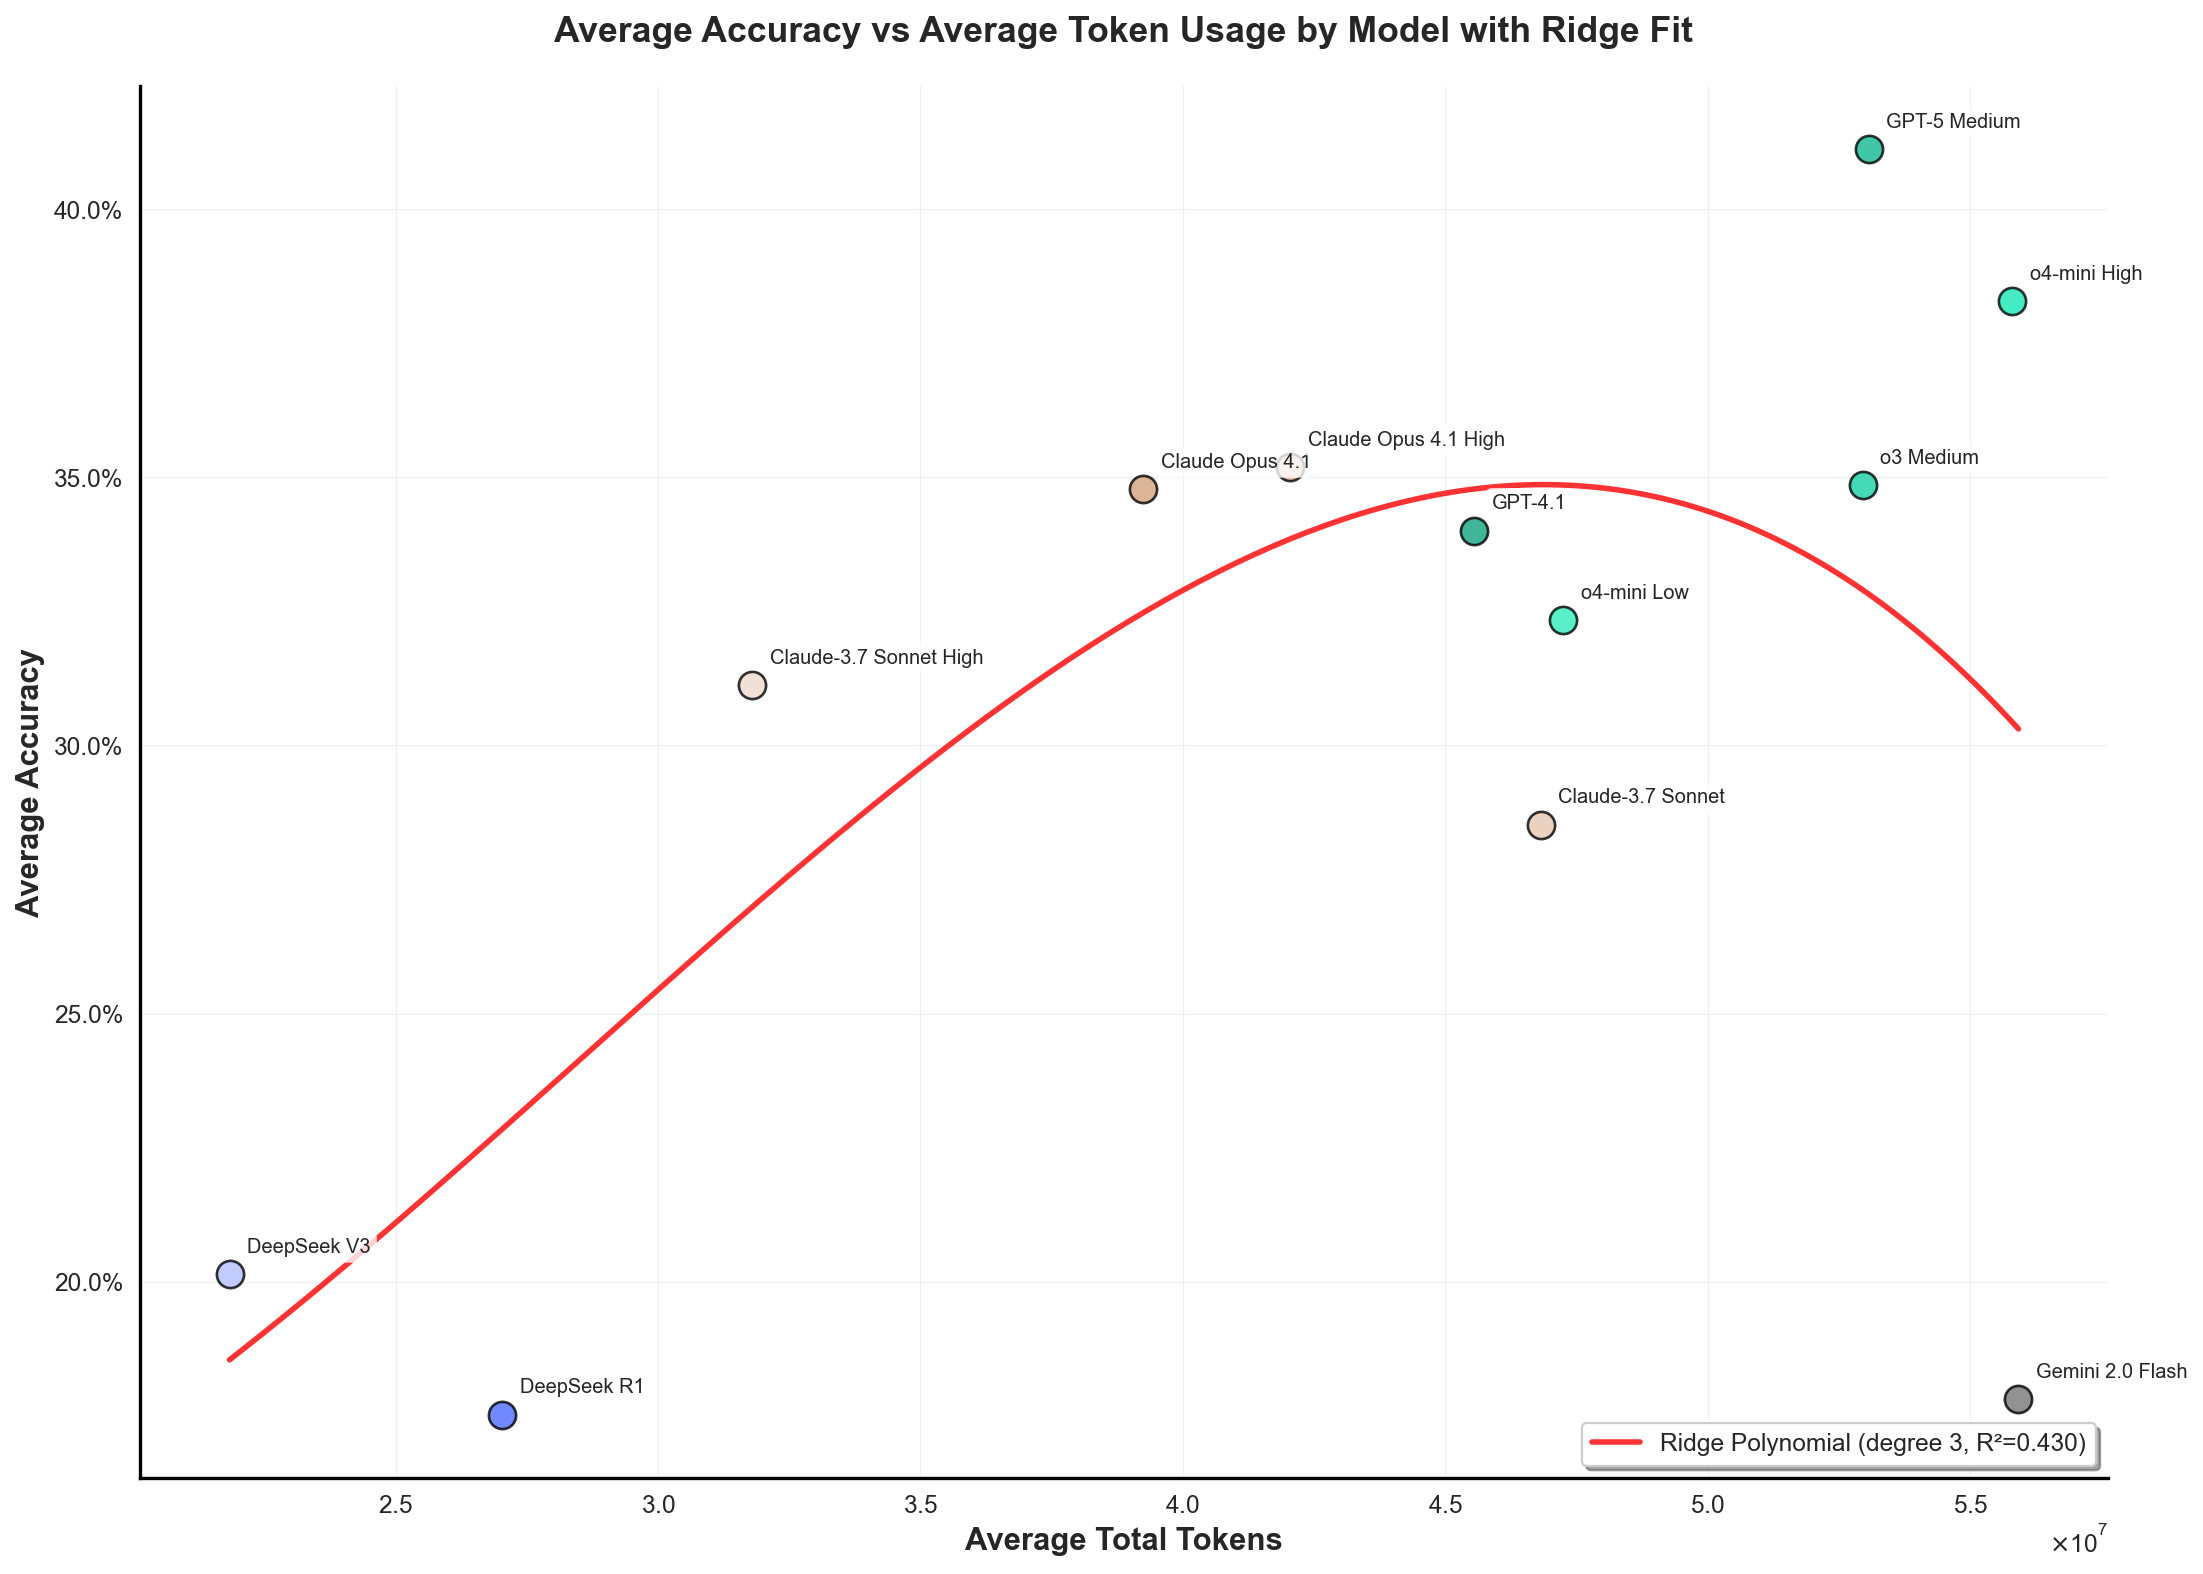


Overall Token Usage and Accuracy Summary:

Models by Efficiency (Accuracy per Token):
  - Claude-3.7 Sonnet High: 31.1% accuracy, 31,793,160 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - DeepSeek V3: 20.1% accuracy, 21,835,537 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - Claude Opus 4.1: 34.8% accuracy, 39,239,472 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - Claude Opus 4.1 High: 35.2% accuracy, 42,042,968 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - GPT-5 Medium: 41.1% accuracy, 53,062,965 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - GPT-4.1: 34.0% accuracy, 45,550,171 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - o4-mini High: 38.3% accuracy, 55,804,380 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - o4-mini Low: 32.3% accuracy, 47,245,635 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - o3 Medium: 34.9% accuracy, 52,947,697 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - DeepSeek R1: 17.

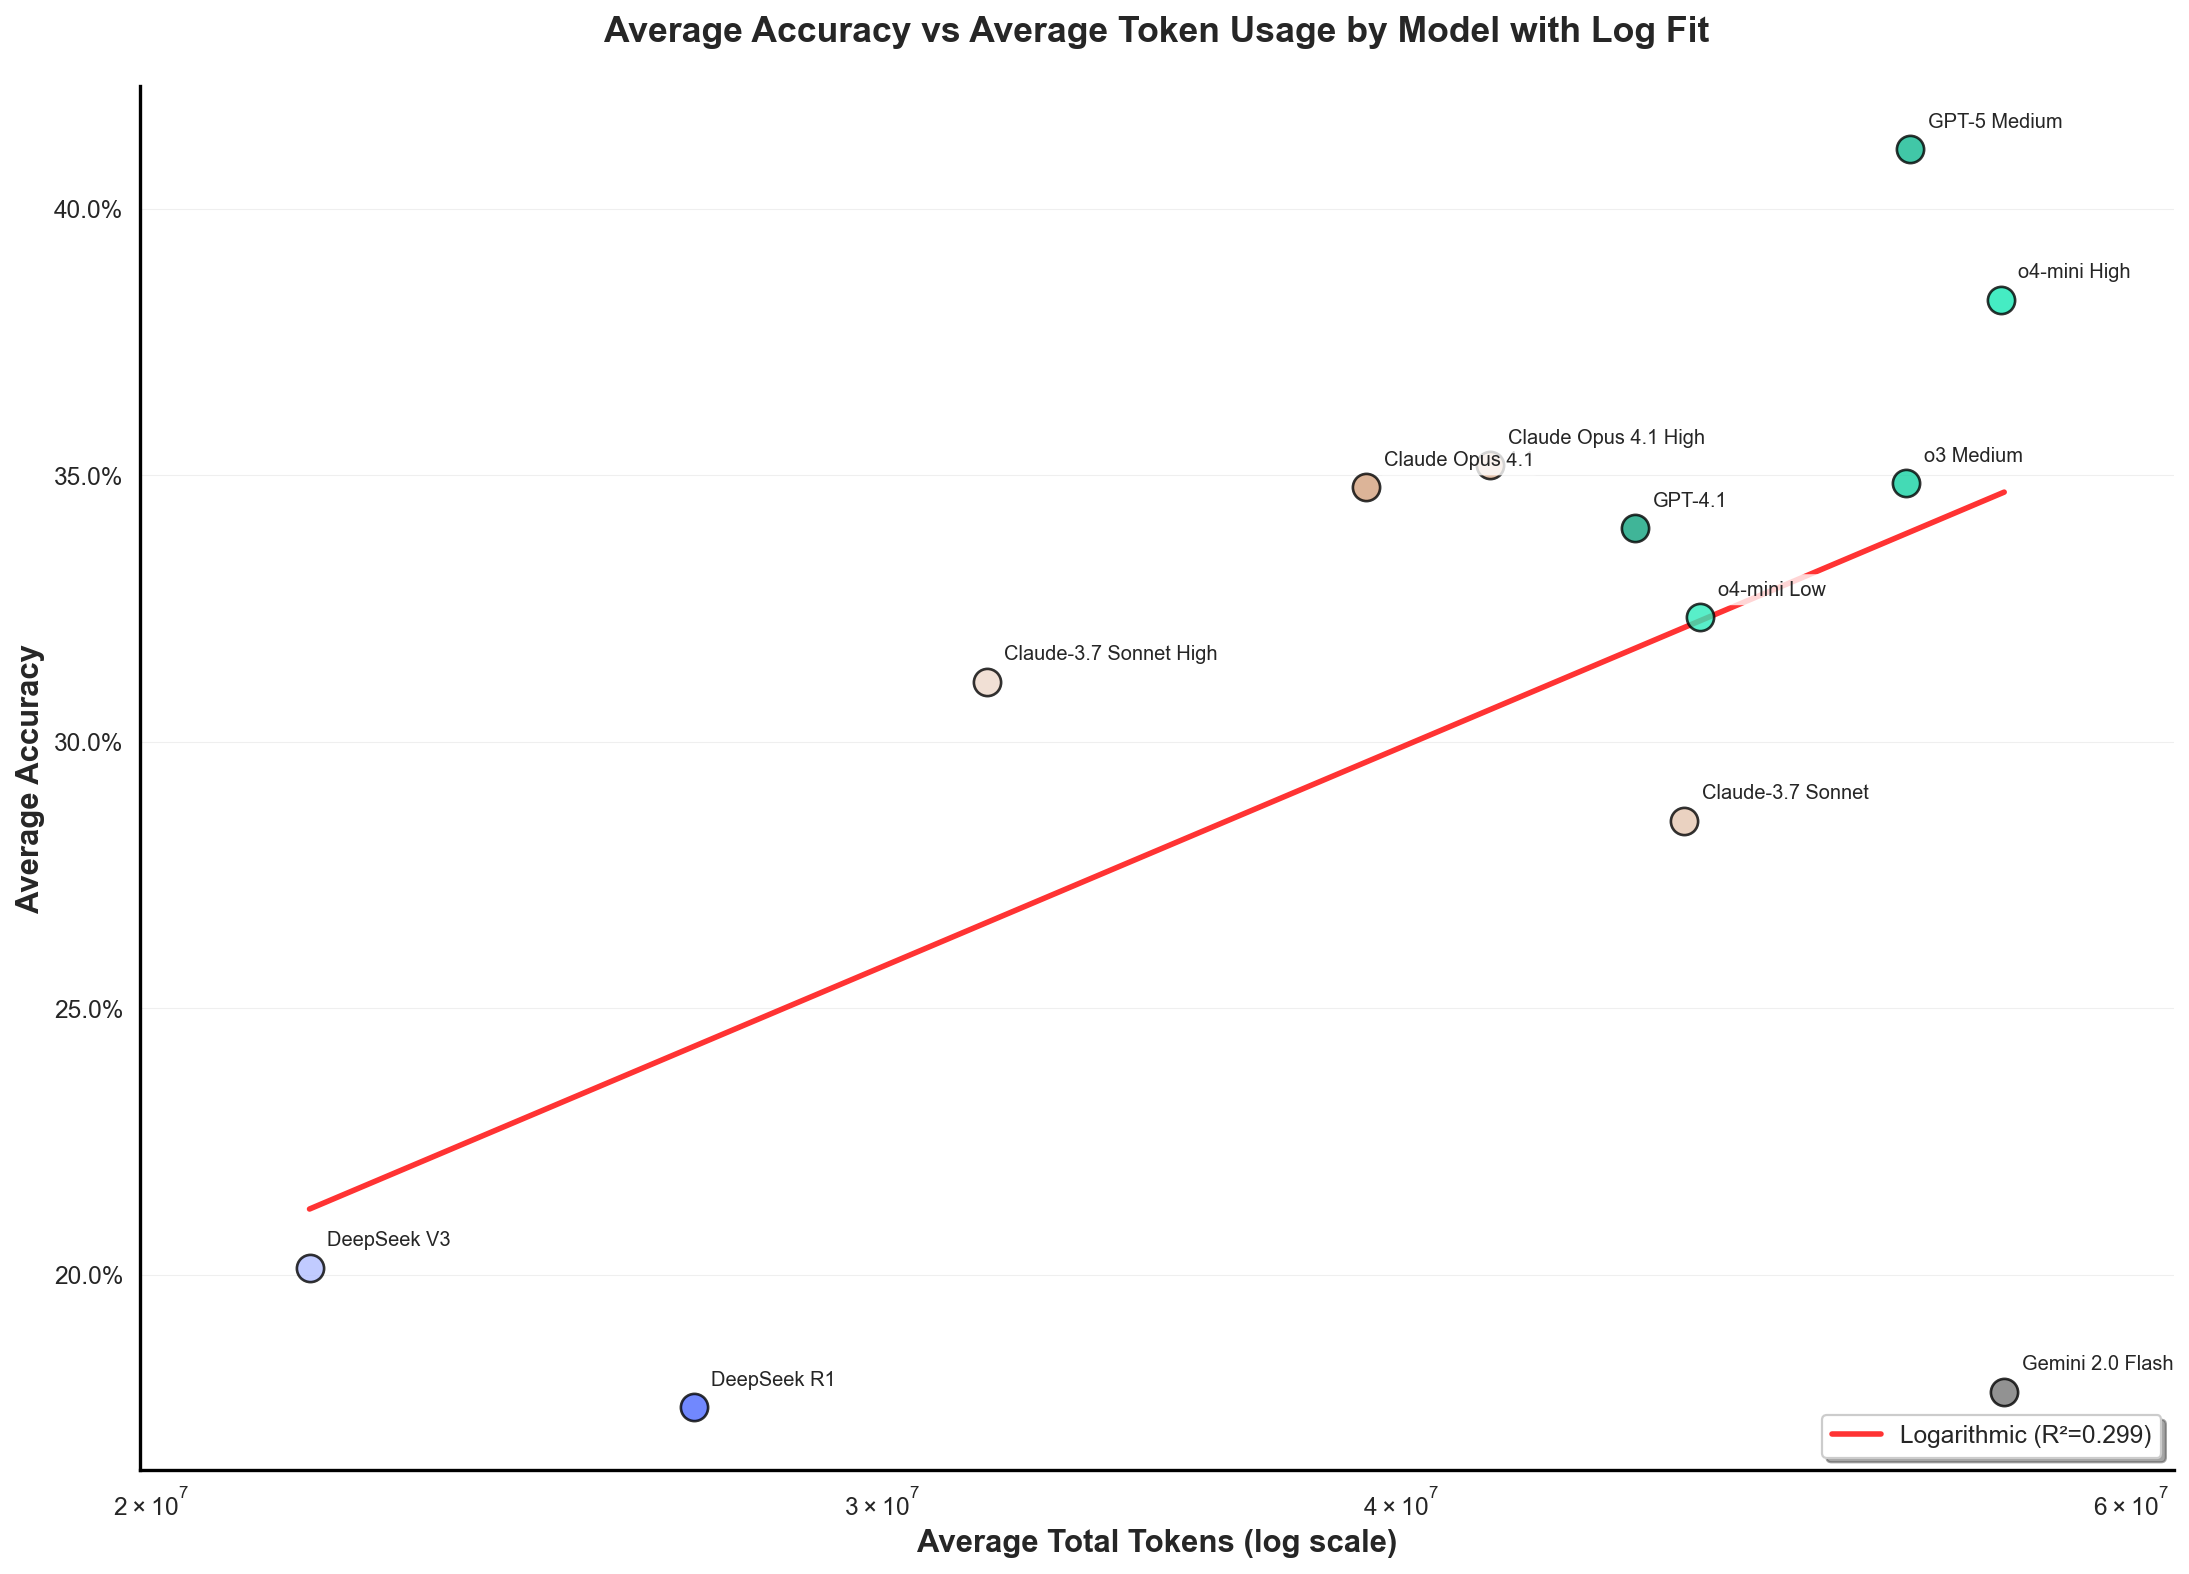


Overall Token Usage and Accuracy Summary:

Models by Efficiency (Accuracy per Token):
  - Claude-3.7 Sonnet High: 31.1% accuracy, 31,793,160 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - DeepSeek V3: 20.1% accuracy, 21,835,537 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - Claude Opus 4.1: 34.8% accuracy, 39,239,472 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - Claude Opus 4.1 High: 35.2% accuracy, 42,042,968 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - GPT-5 Medium: 41.1% accuracy, 53,062,965 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - GPT-4.1: 34.0% accuracy, 45,550,171 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - o4-mini High: 38.3% accuracy, 55,804,380 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - o4-mini Low: 32.3% accuracy, 47,245,635 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - o3 Medium: 34.9% accuracy, 52,947,697 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - DeepSeek R1: 17.

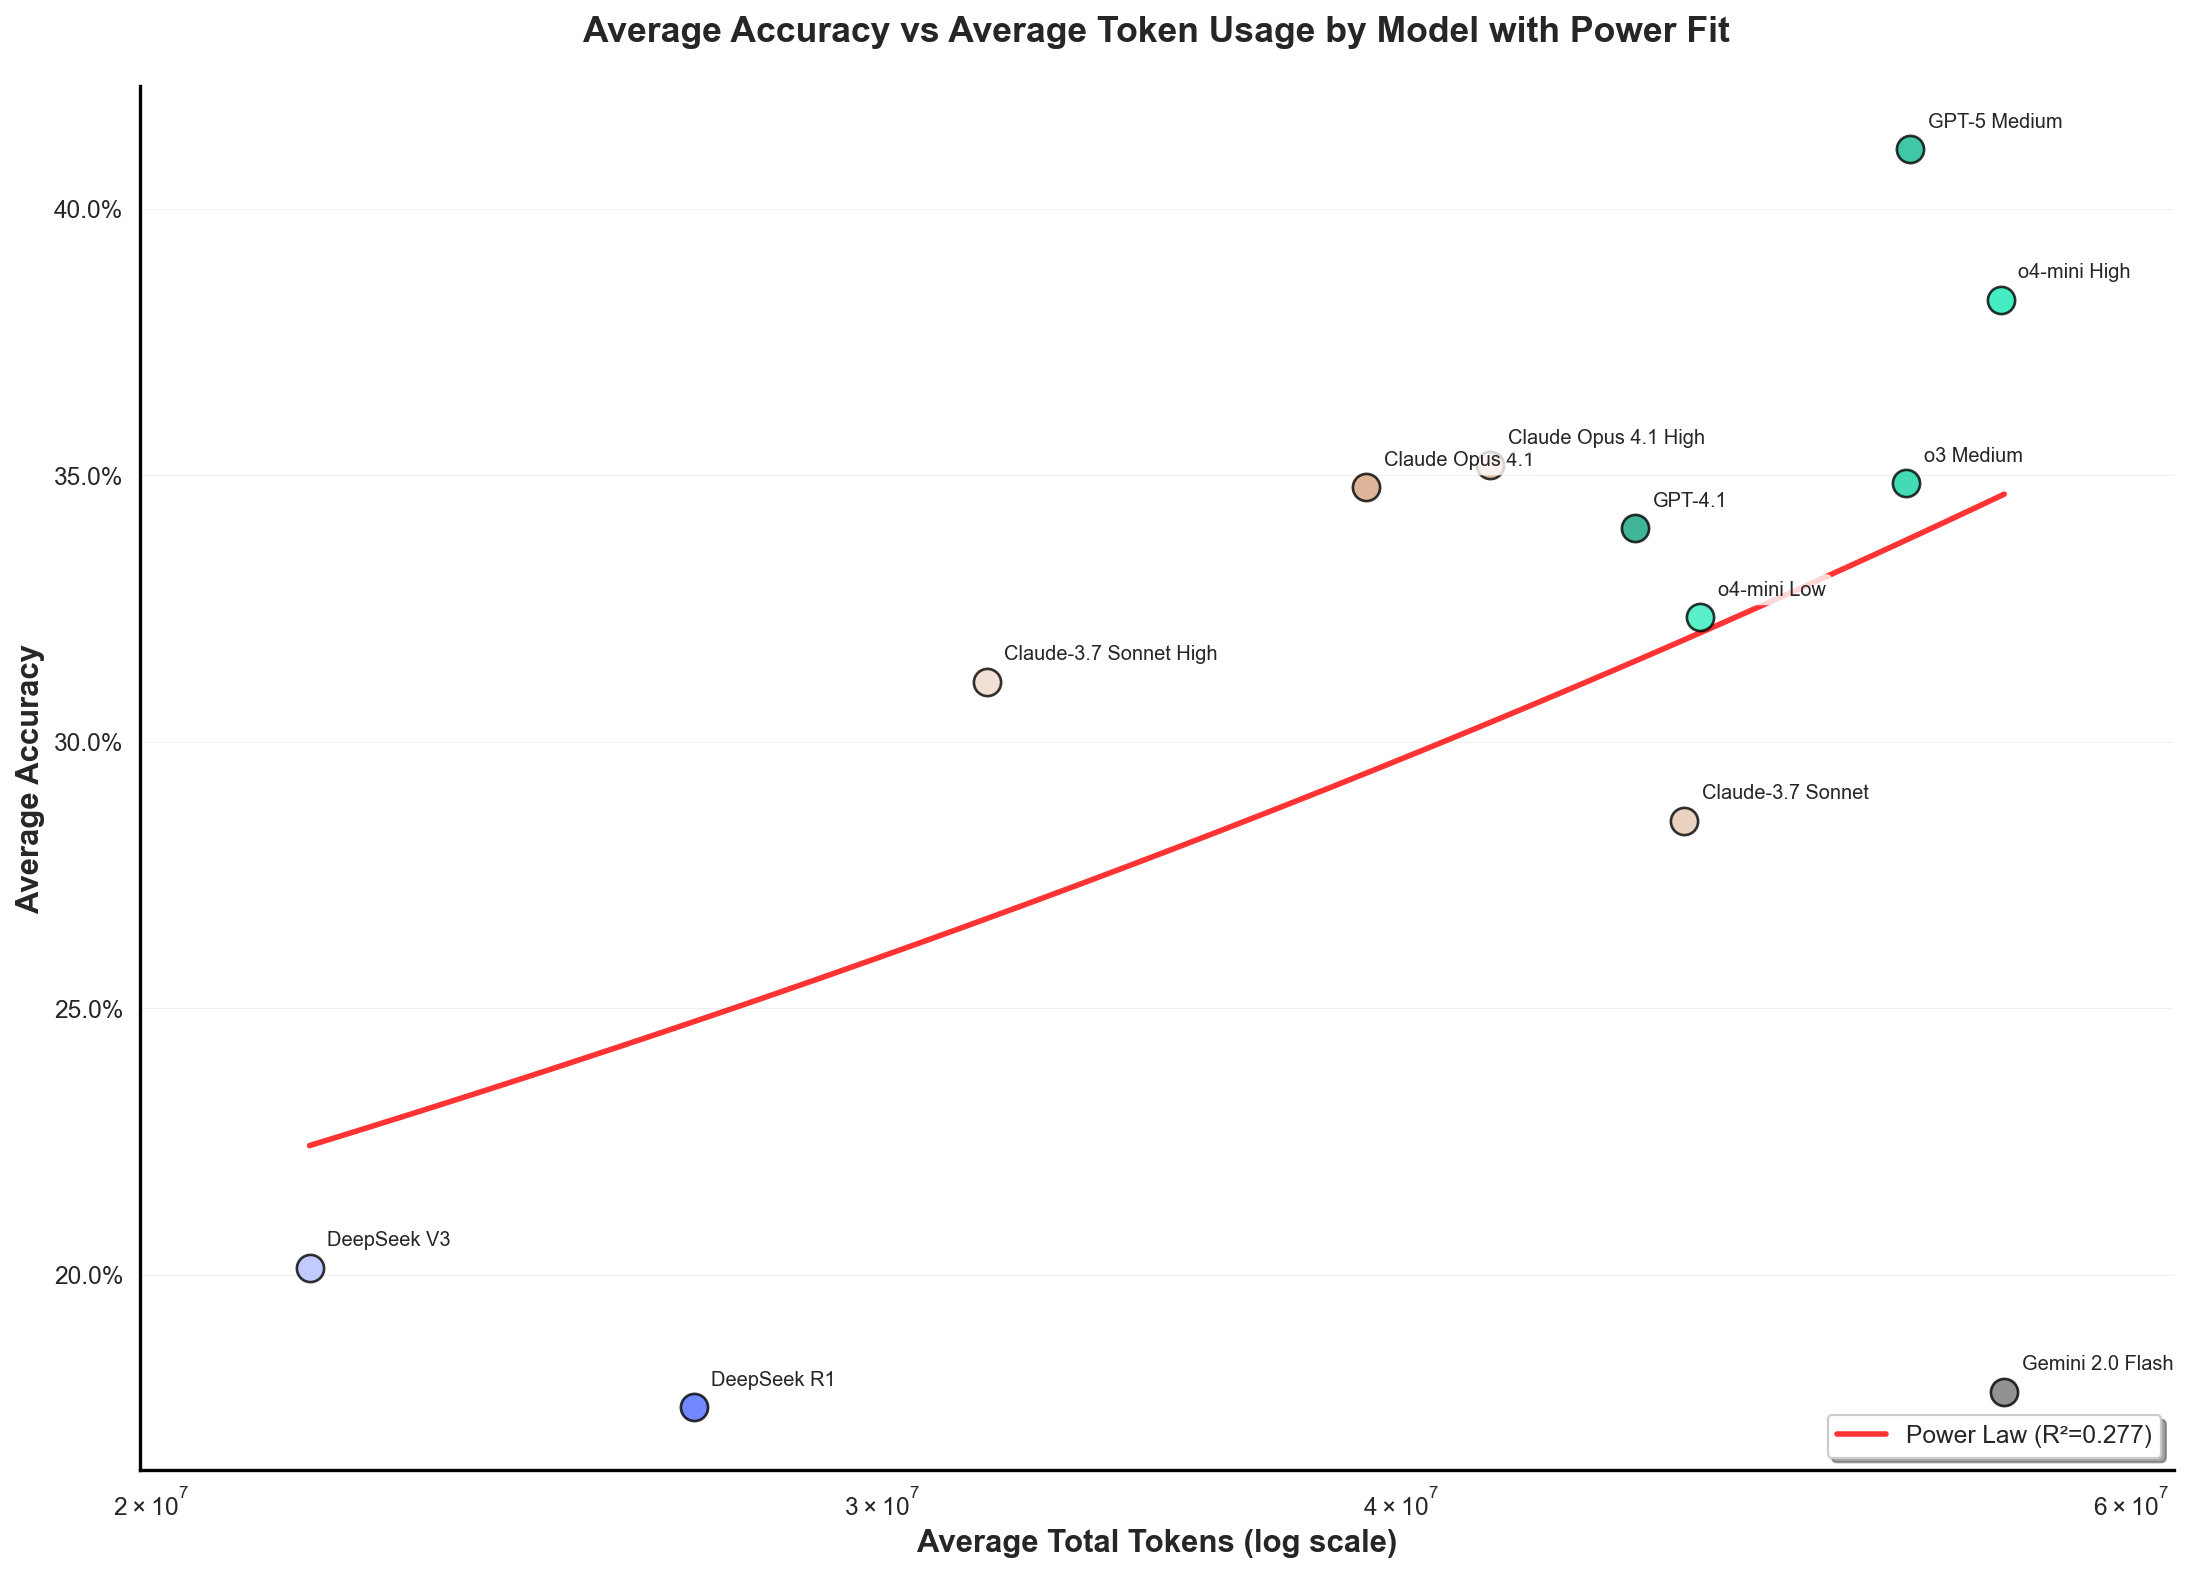


Overall Token Usage and Accuracy Summary:

Models by Efficiency (Accuracy per Token):
  - Claude-3.7 Sonnet High: 31.1% accuracy, 31,793,160 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - DeepSeek V3: 20.1% accuracy, 21,835,537 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - Claude Opus 4.1: 34.8% accuracy, 39,239,472 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - Claude Opus 4.1 High: 35.2% accuracy, 42,042,968 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - GPT-5 Medium: 41.1% accuracy, 53,062,965 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - GPT-4.1: 34.0% accuracy, 45,550,171 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - o4-mini High: 38.3% accuracy, 55,804,380 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - o4-mini Low: 32.3% accuracy, 47,245,635 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - o3 Medium: 34.9% accuracy, 52,947,697 avg tokens, 0.01 accuracy per M tokens, 8 benchmarks
  - DeepSeek R1: 17.

In [15]:
# ═══════════════════════════════════════════════════════════════════
# ACCURACY VS TOKEN USAGE - OVERALL AVERAGES ACROSS ALL BENCHMARKS
# ═══════════════════════════════════════════════════════════════════

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

def plot_accuracy_vs_tokens_overall(df, save_plots=False, use_log_x_axis=False, add_regression=True, regression_type='ridge'):
    """
    Create scatter plot of average accuracy vs average token usage across all benchmarks.
    
    Args:
        df: DataFrame with model data
        save_plots: Whether to save the plot
        use_log_x_axis: Whether to use log scale for x-axis display
        add_regression: Whether to add regression curves
        regression_type: Type of regression ('ridge', 'polynomial', 'log', 'power')
    """
    plt.close('all')
    
    # Set up the plot style matching benchmark_bar_plots
    mpl.rcParams.update({
        "figure.dpi": 160,
        "savefig.dpi": 300,
        "font.size": 10,
        "font.family": "Inter",
        "font.weight": 400,
        "hatch.linewidth": .8,
    })
    sns.set_theme(style="white", rc={"axes.grid": False})
    
    # Filter to only include rows where we have both accuracy and token data
    plot_df = df[(df['accuracy'].notna()) & (df['total_tokens'].notna())].copy()
    
    if plot_df.empty:
        print("No data available with both accuracy and token usage information.")
        return
    
    # Calculate average accuracy and token usage by model across all benchmarks
    model_averages = plot_df.groupby('model').agg(
        avg_accuracy=('accuracy', 'mean'),
        avg_tokens=('total_tokens', 'mean'),
        benchmark_count=('benchmark_name', 'nunique')
    ).reset_index()
    
    # Set up colors for models using the same system as benchmark_bar_plots
    models = model_averages['model'].tolist()
    shade_of = setup_colors(models)
    
    # Prepare data for regression
    X = model_averages['avg_tokens'].values
    y = model_averages['avg_accuracy'].values
    
    # Create figure and axis with better proportions
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Add regression curves if requested
    if add_regression and len(model_averages) >= 3:  # Need at least 3 points for meaningful regression
        
        # Prepare X data for regression (use log if log axis)
        X_reg = np.log(X) if use_log_x_axis and regression_type in ['ridge', 'polynomial'] else X
        
        # Create smooth curve for plotting
        if use_log_x_axis:
            X_smooth_original = np.logspace(np.log10(X.min()), np.log10(X.max()), 200)
            X_smooth_reg = np.log(X_smooth_original) if regression_type in ['ridge', 'polynomial'] else X_smooth_original
        else:
            X_smooth_original = np.linspace(X.min(), X.max(), 200)
            X_smooth_reg = X_smooth_original
        
        try:
            if regression_type == 'ridge':
                # Ridge regression with polynomial features
                degree = min(3, len(model_averages) - 1)  # Avoid overfitting with small datasets
                ridge_poly = make_pipeline(PolynomialFeatures(degree=degree, include_bias=False), 
                                         Ridge(alpha=0.1))
                ridge_poly.fit(X_reg.reshape(-1, 1), y)
                y_pred = ridge_poly.predict(X_smooth_reg.reshape(-1, 1))
                r2 = r2_score(y, ridge_poly.predict(X_reg.reshape(-1, 1)))
                label = f'Ridge Polynomial (degree {degree}, R²={r2:.3f})'
                
            elif regression_type == 'polynomial':
                # Simple polynomial regression
                degree = min(2, len(model_averages) - 1)
                poly_features = PolynomialFeatures(degree=degree, include_bias=True)
                X_poly = poly_features.fit_transform(X_reg.reshape(-1, 1))
                X_smooth_poly = poly_features.transform(X_smooth_reg.reshape(-1, 1))
                coeffs = np.linalg.lstsq(X_poly, y, rcond=None)[0]
                y_pred = X_smooth_poly @ coeffs
                r2 = r2_score(y, X_poly @ coeffs)
                label = f'Polynomial (degree {degree}, R²={r2:.3f})'
                
            elif regression_type == 'log':
                # Logarithmic relationship: y = a * log(x) + b
                def log_func(x, a, b):
                    return a * np.log(x) + b
                
                popt, _ = curve_fit(log_func, X, y)
                y_pred = log_func(X_smooth_original, *popt)
                r2 = r2_score(y, log_func(X, *popt))
                label = f'Logarithmic (R²={r2:.3f})'
                
            elif regression_type == 'power':
                # Power law relationship: y = a * x^b
                def power_func(x, a, b):
                    return a * np.power(x, b)
                
                # Use log-log for initial guess
                log_x, log_y = np.log(X), np.log(y)
                p_init = np.polyfit(log_x, log_y, 1)
                initial_guess = [np.exp(p_init[1]), p_init[0]]
                
                popt, _ = curve_fit(power_func, X, y, p0=initial_guess)
                y_pred = power_func(X_smooth_original, *popt)
                r2 = r2_score(y, power_func(X, *popt))
                label = f'Power Law (R²={r2:.3f})'
            
            # Plot the regression curve
            ax.plot(X_smooth_original, y_pred, 
                   color='red', linewidth=2.5, alpha=0.8, zorder=1,
                   label=label)
            
            print(f"Regression R² score: {r2:.3f}")
            
        except Exception as e:
            print(f"Warning: Could not fit {regression_type} regression: {e}")
    
    # Create scatter plot with company colors and add labels
    for _, row in model_averages.iterrows():
        model = row['model']
        x = row['avg_tokens']
        y = row['avg_accuracy']
        
        # Plot the point
        ax.scatter(
            x, y,
            color=shade_of.get(model, '#777777'),
            s=150,
            edgecolor='black',
            linewidth=1.2,
            alpha=0.8,
            zorder=3
        )
        
        # Add text label for the point
        ax.annotate(
            model,
            (x, y),
            xytext=(8, 8),  # Offset the text slightly from the point
            textcoords='offset points',
            fontsize=9,
            fontweight='normal',
            ha='left',
            va='bottom',
            bbox=dict(boxstyle='round,pad=0.3', 
                     facecolor='white', alpha=0.8, 
                     edgecolor='none'),
            zorder=4
        )
    
    # Style the axes to match benchmark_bar_plots
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    for spine in ('left', 'bottom'):
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_linewidth(1.5)
        ax.spines[spine].set_color('black')
    
    ax.tick_params(axis='both', which='major', color='black', width=1, length=4)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=1)
    
    # Set x-axis scale
    if use_log_x_axis:
        ax.set_xscale('log')
        x_label = 'Average Total Tokens (log scale)'
        # Set reasonable margins for log scale
        x_min, x_max = model_averages['avg_tokens'].min(), model_averages['avg_tokens'].max()
        x_range = x_max / x_min
        margin_factor = 0.1
        ax.set_xlim(x_min / (x_range**margin_factor), x_max * (x_range**margin_factor))
    else:
        x_label = 'Average Total Tokens'
        # Set margins for linear scale
        x_margin = (model_averages['avg_tokens'].max() - model_averages['avg_tokens'].min()) * 0.05
        ax.set_xlim(model_averages['avg_tokens'].min() - x_margin, model_averages['avg_tokens'].max() + x_margin)
    
    # Set labels and title
    ax.set_xlabel(x_label, fontsize=14, fontweight='bold')
    ax.set_ylabel('Average Accuracy', fontsize=14, fontweight='bold')
    
    title_suffix = f' with {regression_type.title()} Fit' if add_regression else ''
    ax.set_title(f'Average Accuracy vs Average Token Usage by Model{title_suffix}', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    # Format x-axis for tokens
    if not use_log_x_axis:
        ax.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
        ax.xaxis.major.formatter._useMathText = True
    
    # Set y-axis limits with some padding
    y_margin = (model_averages['avg_accuracy'].max() - model_averages['avg_accuracy'].min()) * 0.05
    ax.set_ylim(model_averages['avg_accuracy'].min() - y_margin, model_averages['avg_accuracy'].max() + y_margin)
    
    # Add legend for regression line
    if add_regression:
        ax.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout()
    
    # Save plot if requested
    if save_plots:
        output_path = str(quantitative_dir / "plots/")
        suffix = "_logx" if use_log_x_axis else ""
        suffix += f"_{regression_type}" if add_regression else ""
        output_filename = f"accuracy_vs_tokens_overall{suffix}.png"
        fig.savefig(os.path.join(output_path, output_filename), bbox_inches='tight', dpi=300)
        print(f"Saved plot: {output_filename}")
    
    # Show plot
    plt.show()
    
    # Print summary statistics
    print(f"\nOverall Token Usage and Accuracy Summary:")
    print("=" * 60)
    
    # Sort by efficiency (accuracy per token)
    model_averages['tokens_per_accuracy'] = model_averages['avg_tokens'] / model_averages['avg_accuracy']
    model_averages['accuracy_per_token'] = model_averages['avg_accuracy'] / model_averages['avg_tokens']
    
    # Sort by accuracy per token (efficiency) descending
    efficiency_sorted = model_averages.sort_values('accuracy_per_token', ascending=False)
    
    print(f"\nModels by Efficiency (Accuracy per Token):")
    for _, row in efficiency_sorted.iterrows():
        efficiency = row['accuracy_per_token'] * 1e6  # Per million tokens for readability
        print(f"  - {row['model']}: {row['avg_accuracy']:.1%} accuracy, "
              f"{row['avg_tokens']:,.0f} avg tokens, "
              f"{efficiency:.2f} accuracy per M tokens, "
              f"{row['benchmark_count']} benchmarks")
    
    return model_averages

# Create multiple versions with different regression types
print("Creating overall accuracy vs token usage plots with regression curves...")

print("\n=== Linear Scale with Ridge Regression ===")
model_stats_ridge = plot_accuracy_vs_tokens_overall(model_df, save_plots=True, use_log_x_axis=False, 
                                                   add_regression=True, regression_type='ridge')

print("\n=== Log Scale with Logarithmic Regression ===")
model_stats_log = plot_accuracy_vs_tokens_overall(model_df, save_plots=True, use_log_x_axis=True, 
                                                 add_regression=True, regression_type='log')

print("\n=== Log Scale with Power Law Regression ===")
model_stats_power = plot_accuracy_vs_tokens_overall(model_df, save_plots=True, use_log_x_axis=True, 
                                                   add_regression=True, regression_type='power')

Creating reasoning level comparison analysis...
Found 52 entries for reasoning models:
['Claude Opus 4.1' 'Claude Opus 4.1 High' 'Claude-3.7 Sonnet'
 'Claude-3.7 Sonnet High' 'o4-mini High' 'o4-mini Low']

Found 3 base models with multiple reasoning levels:
  Opus-4.1: Standard, High
  Sonnet-3.7: Standard, High
  o4-mini: High, Low


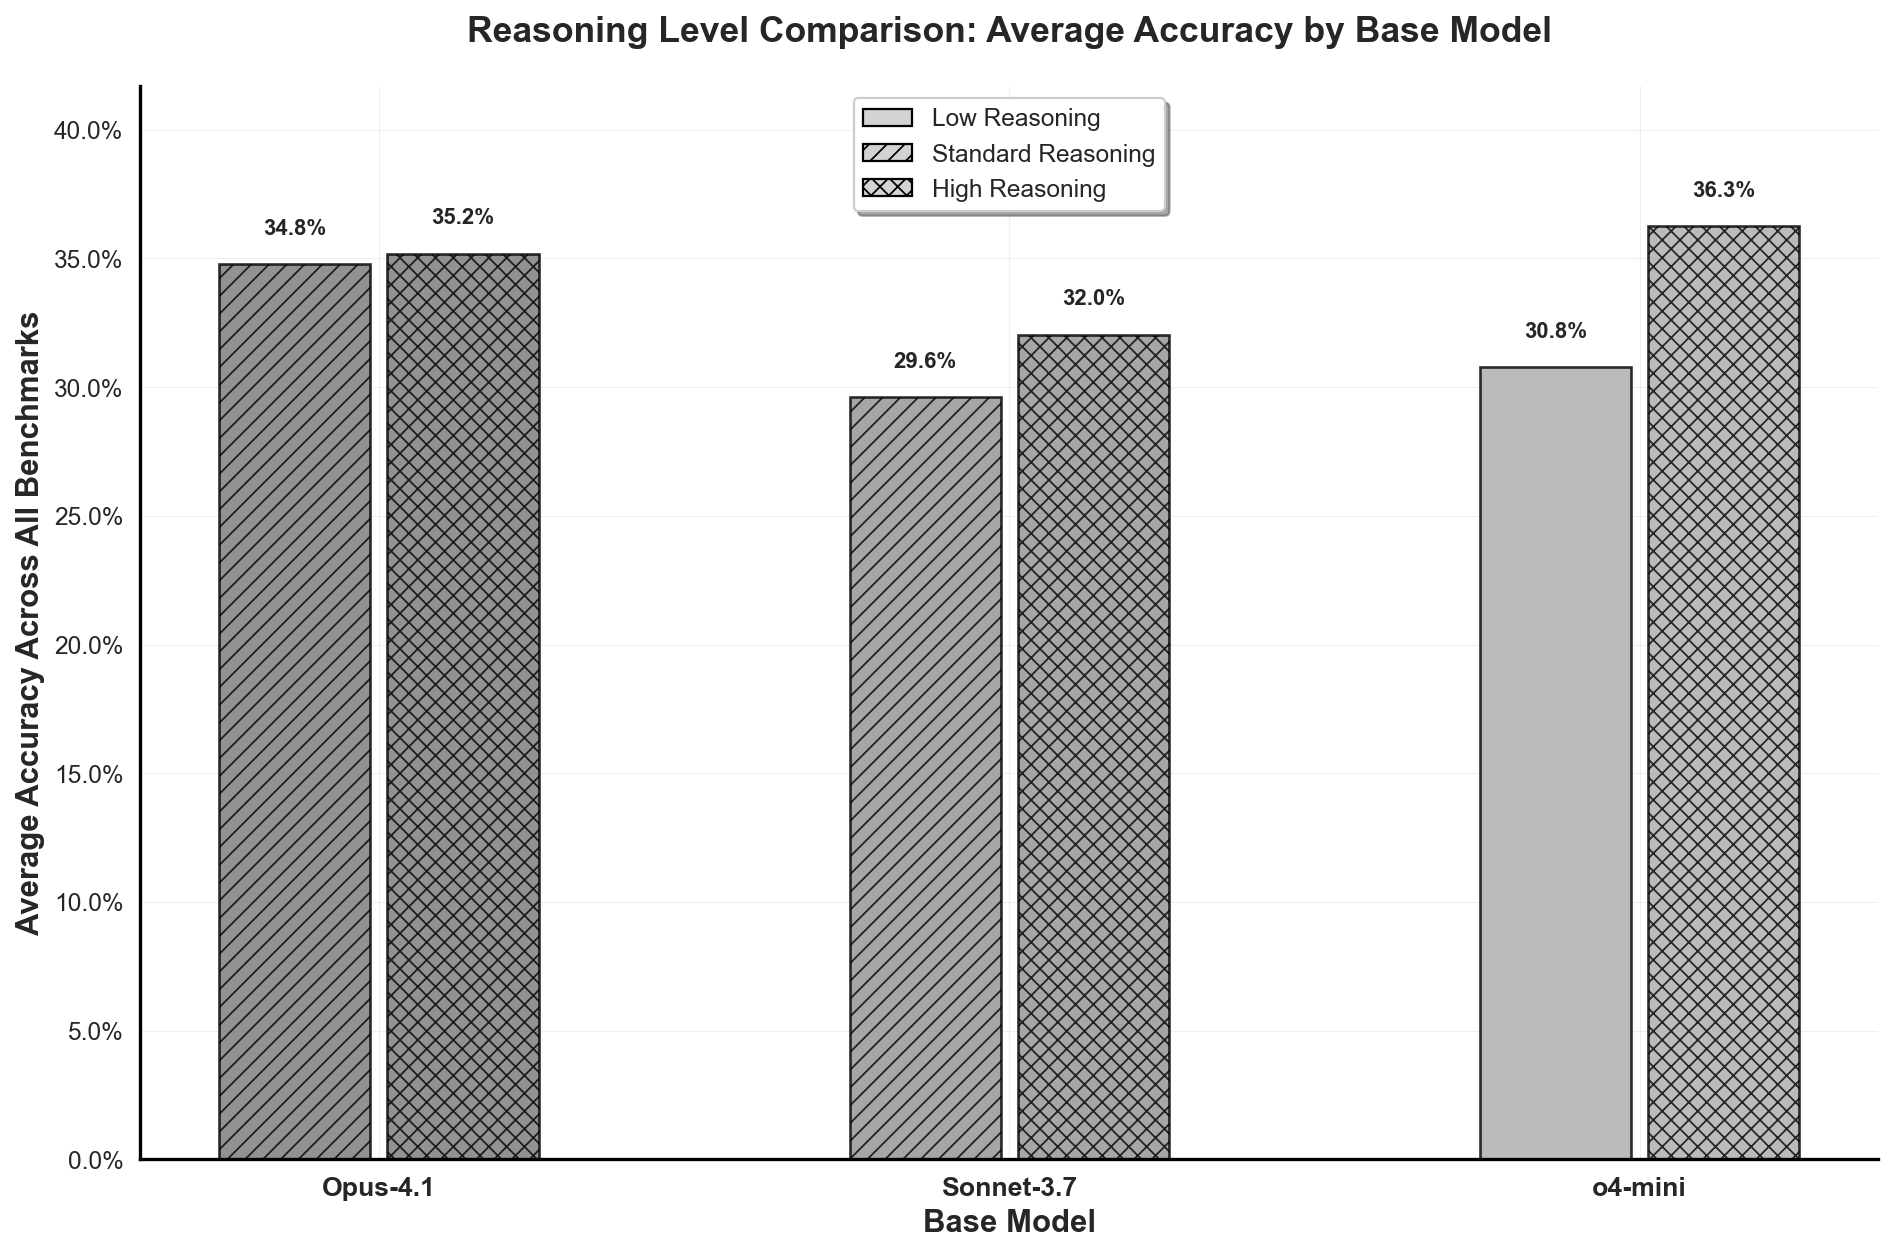

Saved plot: reasoning_level_comparison.png

Detailed Reasoning Level Statistics:

Opus-4.1:
  High: 35.2% average accuracy across 8 benchmarks
  Standard: 34.8% average accuracy across 8 benchmarks

Sonnet-3.7:
  High: 32.0% average accuracy across 9 benchmarks
  Standard: 29.6% average accuracy across 9 benchmarks

o4-mini:
  High: 36.3% average accuracy across 9 benchmarks
  Low: 30.8% average accuracy across 9 benchmarks


In [ ]:
# ═══════════════════════════════════════════════════════════════════
# REASONING LEVEL COMPARISON (o4, Sonnet, Opus models only)
# ═══════════════════════════════════════════════════════════════════

def plot_reasoning_level_comparison(df, save_plots=False):
    """
    Filter to models with multiple reasoning levels (o4, Sonnet, Opus) and 
    show average accuracy across all benchmarks for each reasoning level pair.
    """
    plt.close('all')
    
    # Set up the plot style
    mpl.rcParams.update({
        "figure.dpi": 160,
        "savefig.dpi": 300,
        "font.size": 12,
        "hatch.linewidth": .8,
        "font.family": "Inter",
        "font.weight": 400,
    })
    sns.set_theme(style="white", rc={"axes.grid": False})
    
    # Filter to models containing o4, Sonnet, or Opus
    reasoning_models = df[
        df['model'].str.contains('o4|Sonnet|Opus', case=False, na=False)
    ].copy()
    
    if reasoning_models.empty:
        print("No reasoning models found matching the criteria.")
        return
    
    print(f"Found {len(reasoning_models)} entries for reasoning models:")
    print(reasoning_models['model'].unique())
    
    # Extract base model name and reasoning level
    def extract_model_info(model_name):
        """Extract base model and reasoning level from model name."""
        model_name = str(model_name)
        
        # Handle o4 models
        if 'o4' in model_name.lower():
            if 'high' in model_name.lower():
                return 'o4-mini', 'High'
            elif 'low' in model_name.lower():
                return 'o4-mini', 'Low'
            else:
                return 'o4-mini', 'Medium'  # Default for o4 without explicit level
        
        # Handle Sonnet models
        elif 'sonnet' in model_name.lower():
            if 'high' in model_name.lower():
                return 'Sonnet-3.7', 'High'
            else:
                return 'Sonnet-3.7', 'Standard'
        
        # Handle Opus models
        elif 'opus' in model_name.lower():
            if 'high' in model_name.lower():
                return 'Opus-4.1', 'High'
            else:
                return 'Opus-4.1', 'Standard'
        
        return None, None
    
    # Extract model info
    reasoning_models[['base_model', 'reasoning_level']] = reasoning_models['model'].apply(
        lambda x: pd.Series(extract_model_info(x))
    )
    
    # Filter out any models where we couldn't extract info
    reasoning_models = reasoning_models.dropna(subset=['base_model', 'reasoning_level'])
    
    if reasoning_models.empty:
        print("No valid reasoning level models found after processing.")
        return
    
    # Check which base models have multiple reasoning levels
    level_counts = reasoning_models.groupby('base_model')['reasoning_level'].nunique()
    multi_level_models = level_counts[level_counts > 1].index.tolist()
    
    if not multi_level_models:
        print("No models found with multiple reasoning levels.")
        print("Available base models and their levels:")
        for base_model in reasoning_models['base_model'].unique():
            levels = reasoning_models[reasoning_models['base_model'] == base_model]['reasoning_level'].unique()
            print(f"  {base_model}: {', '.join(levels)}")
        return
    
    # Filter to only multi-level models
    multi_level_data = reasoning_models[
        reasoning_models['base_model'].isin(multi_level_models)
    ].copy()
    
    print(f"\nFound {len(multi_level_models)} base models with multiple reasoning levels:")
    for base_model in multi_level_models:
        levels = multi_level_data[multi_level_data['base_model'] == base_model]['reasoning_level'].unique()
        print(f"  {base_model}: {', '.join(levels)}")
    
    # Calculate average accuracy across all benchmarks for each base_model + reasoning_level
    avg_accuracy = multi_level_data.groupby(['base_model', 'reasoning_level'])['accuracy'].mean().reset_index()
    
    # Set up colors for base models using our existing color scheme
    base_models = avg_accuracy['base_model'].unique()
    shade_of = setup_colors([f"{bm} Standard" for bm in base_models])  # Use existing color setup
    base_model_colors = {}
    for bm in base_models:
        if f"{bm} Standard" in shade_of:
            base_model_colors[bm] = shade_of[f"{bm} Standard"]
        elif f"{bm} High" in shade_of:
            base_model_colors[bm] = shade_of[f"{bm} High"] 
        else:
            # Fallback based on company
            if 'o4' in bm.lower():
                base_model_colors[bm] = BRAND_BASE.get("OpenAI", "#10A37F")
            elif 'sonnet' in bm.lower():
                base_model_colors[bm] = BRAND_BASE.get("Anthropic", "#D4A27F")
            elif 'opus' in bm.lower():
                base_model_colors[bm] = BRAND_BASE.get("Anthropic", "#D4A27F")
            else:
                base_model_colors[bm] = "#777777"
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Define reasoning level order and colors
    level_order = ['Low', 'Standard', 'Medium', 'High']
    level_patterns = {'Low': '', 'Standard': '///', 'Medium': '...', 'High': 'xxx'}
    
    # Set up x positions
    x_positions = []
    x_labels = []
    bar_data = []
    
    x_pos = 0
    group_width = 0.8
    n_levels_per_model = {}
    
    # Calculate positions for each base model group
    for base_model in sorted(multi_level_models):
        model_data = avg_accuracy[avg_accuracy['base_model'] == base_model]
        levels = model_data['reasoning_level'].tolist()
        n_levels = len(levels)
        n_levels_per_model[base_model] = n_levels
        
        # Sort levels by the defined order
        levels_ordered = [level for level in level_order if level in levels]
        
        # Calculate bar positions within this group
        if n_levels == 1:
            bar_positions = [x_pos]
        else:
            bar_width = group_width / n_levels
            start_pos = x_pos - group_width/2 + bar_width/2
            bar_positions = [start_pos + i * bar_width for i in range(n_levels)]
        
        # Store bar data
        for i, level in enumerate(levels_ordered):
            acc_val = model_data[model_data['reasoning_level'] == level]['accuracy'].iloc[0]
            bar_data.append({
                'base_model': base_model,
                'level': level,
                'accuracy': acc_val,
                'x_pos': bar_positions[i],
                'color': base_model_colors[base_model],
                'pattern': level_patterns.get(level, '')
            })
        
        x_positions.append(x_pos)
        x_labels.append(base_model)
        x_pos += 1.5  # Space between model groups
    
    # Plot the bars
    for bar in bar_data:
        bars = ax.bar(
            bar['x_pos'], 
            bar['accuracy'],
            width=0.4 if n_levels_per_model[bar['base_model']] == 1 else group_width / n_levels_per_model[bar['base_model']] * 0.9,
            color=bar['color'],
            edgecolor='black',
            linewidth=1.2,
            hatch=bar['pattern'],
            alpha=0.8,
            label=f"{bar['base_model']} {bar['level']}" if bar['level'] != 'Standard' else bar['base_model']
        )
        
        # Add value labels on bars
        height = bar['accuracy']
        ax.text(bar['x_pos'], height + 0.01, f"{height:.1%}", 
               ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Customize the plot
    ax.set_xlabel('Base Model', fontsize=14, fontweight='bold')
    ax.set_ylabel('Average Accuracy Across All Benchmarks', fontsize=14, fontweight='bold')
    ax.set_title('Reasoning Level Comparison: Average Accuracy by Base Model', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Set x-axis
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, fontsize=12, fontweight='bold')
    
    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    # Style axes
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    for spine in ('left', 'bottom'):
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_linewidth(1.5)
        ax.spines[spine].set_color('black')
    
    ax.tick_params(axis='both', which='major', color='black', width=1, length=4)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=1)
    
    # Add legend for reasoning levels
    legend_elements = []
    used_levels = set([bar['level'] for bar in bar_data])
    for level in level_order:
        if level in used_levels:
            legend_elements.append(Patch(facecolor='lightgray', hatch=level_patterns[level], 
                                       edgecolor='black', label=f'{level} Reasoning'))
    
    if len(legend_elements) > 1:
        ax.legend(handles=legend_elements, loc='upper center', frameon=True, fancybox=True, shadow=True)
    
    # Set y-axis limits with some padding
    max_acc = max([bar['accuracy'] for bar in bar_data])
    ax.set_ylim(0, max_acc * 1.15)
    
    plt.tight_layout()
    plt.show()
    
    # Save plot if requested
    if save_plots:
        output_path = str(quantitative_dir / "plots/")
        output_filename = "reasoning_level_comparison.png"
        fig.savefig(os.path.join(output_path, output_filename), bbox_inches='tight', dpi=300)
        print(f"Saved plot: {output_filename}")
    
    # Print detailed statistics
    print(f"\nDetailed Reasoning Level Statistics:")
    for base_model in sorted(multi_level_models):
        print(f"\n{base_model}:")
        model_data = avg_accuracy[avg_accuracy['base_model'] == base_model].sort_values('accuracy', ascending=False)
        for _, row in model_data.iterrows():
            level_data = multi_level_data[
                (multi_level_data['base_model'] == base_model) & 
                (multi_level_data['reasoning_level'] == row['reasoning_level'])
            ]
            n_benchmarks = len(level_data)
            print(f"  {row['reasoning_level']}: {row['accuracy']:.1%} average accuracy across {n_benchmarks} benchmarks")

# Create the reasoning level comparison plot
print("Creating reasoning level comparison analysis...")
plot_reasoning_level_comparison(filtered_df, save_plots=True)

Creating reasoning level efficiency scatter plot...


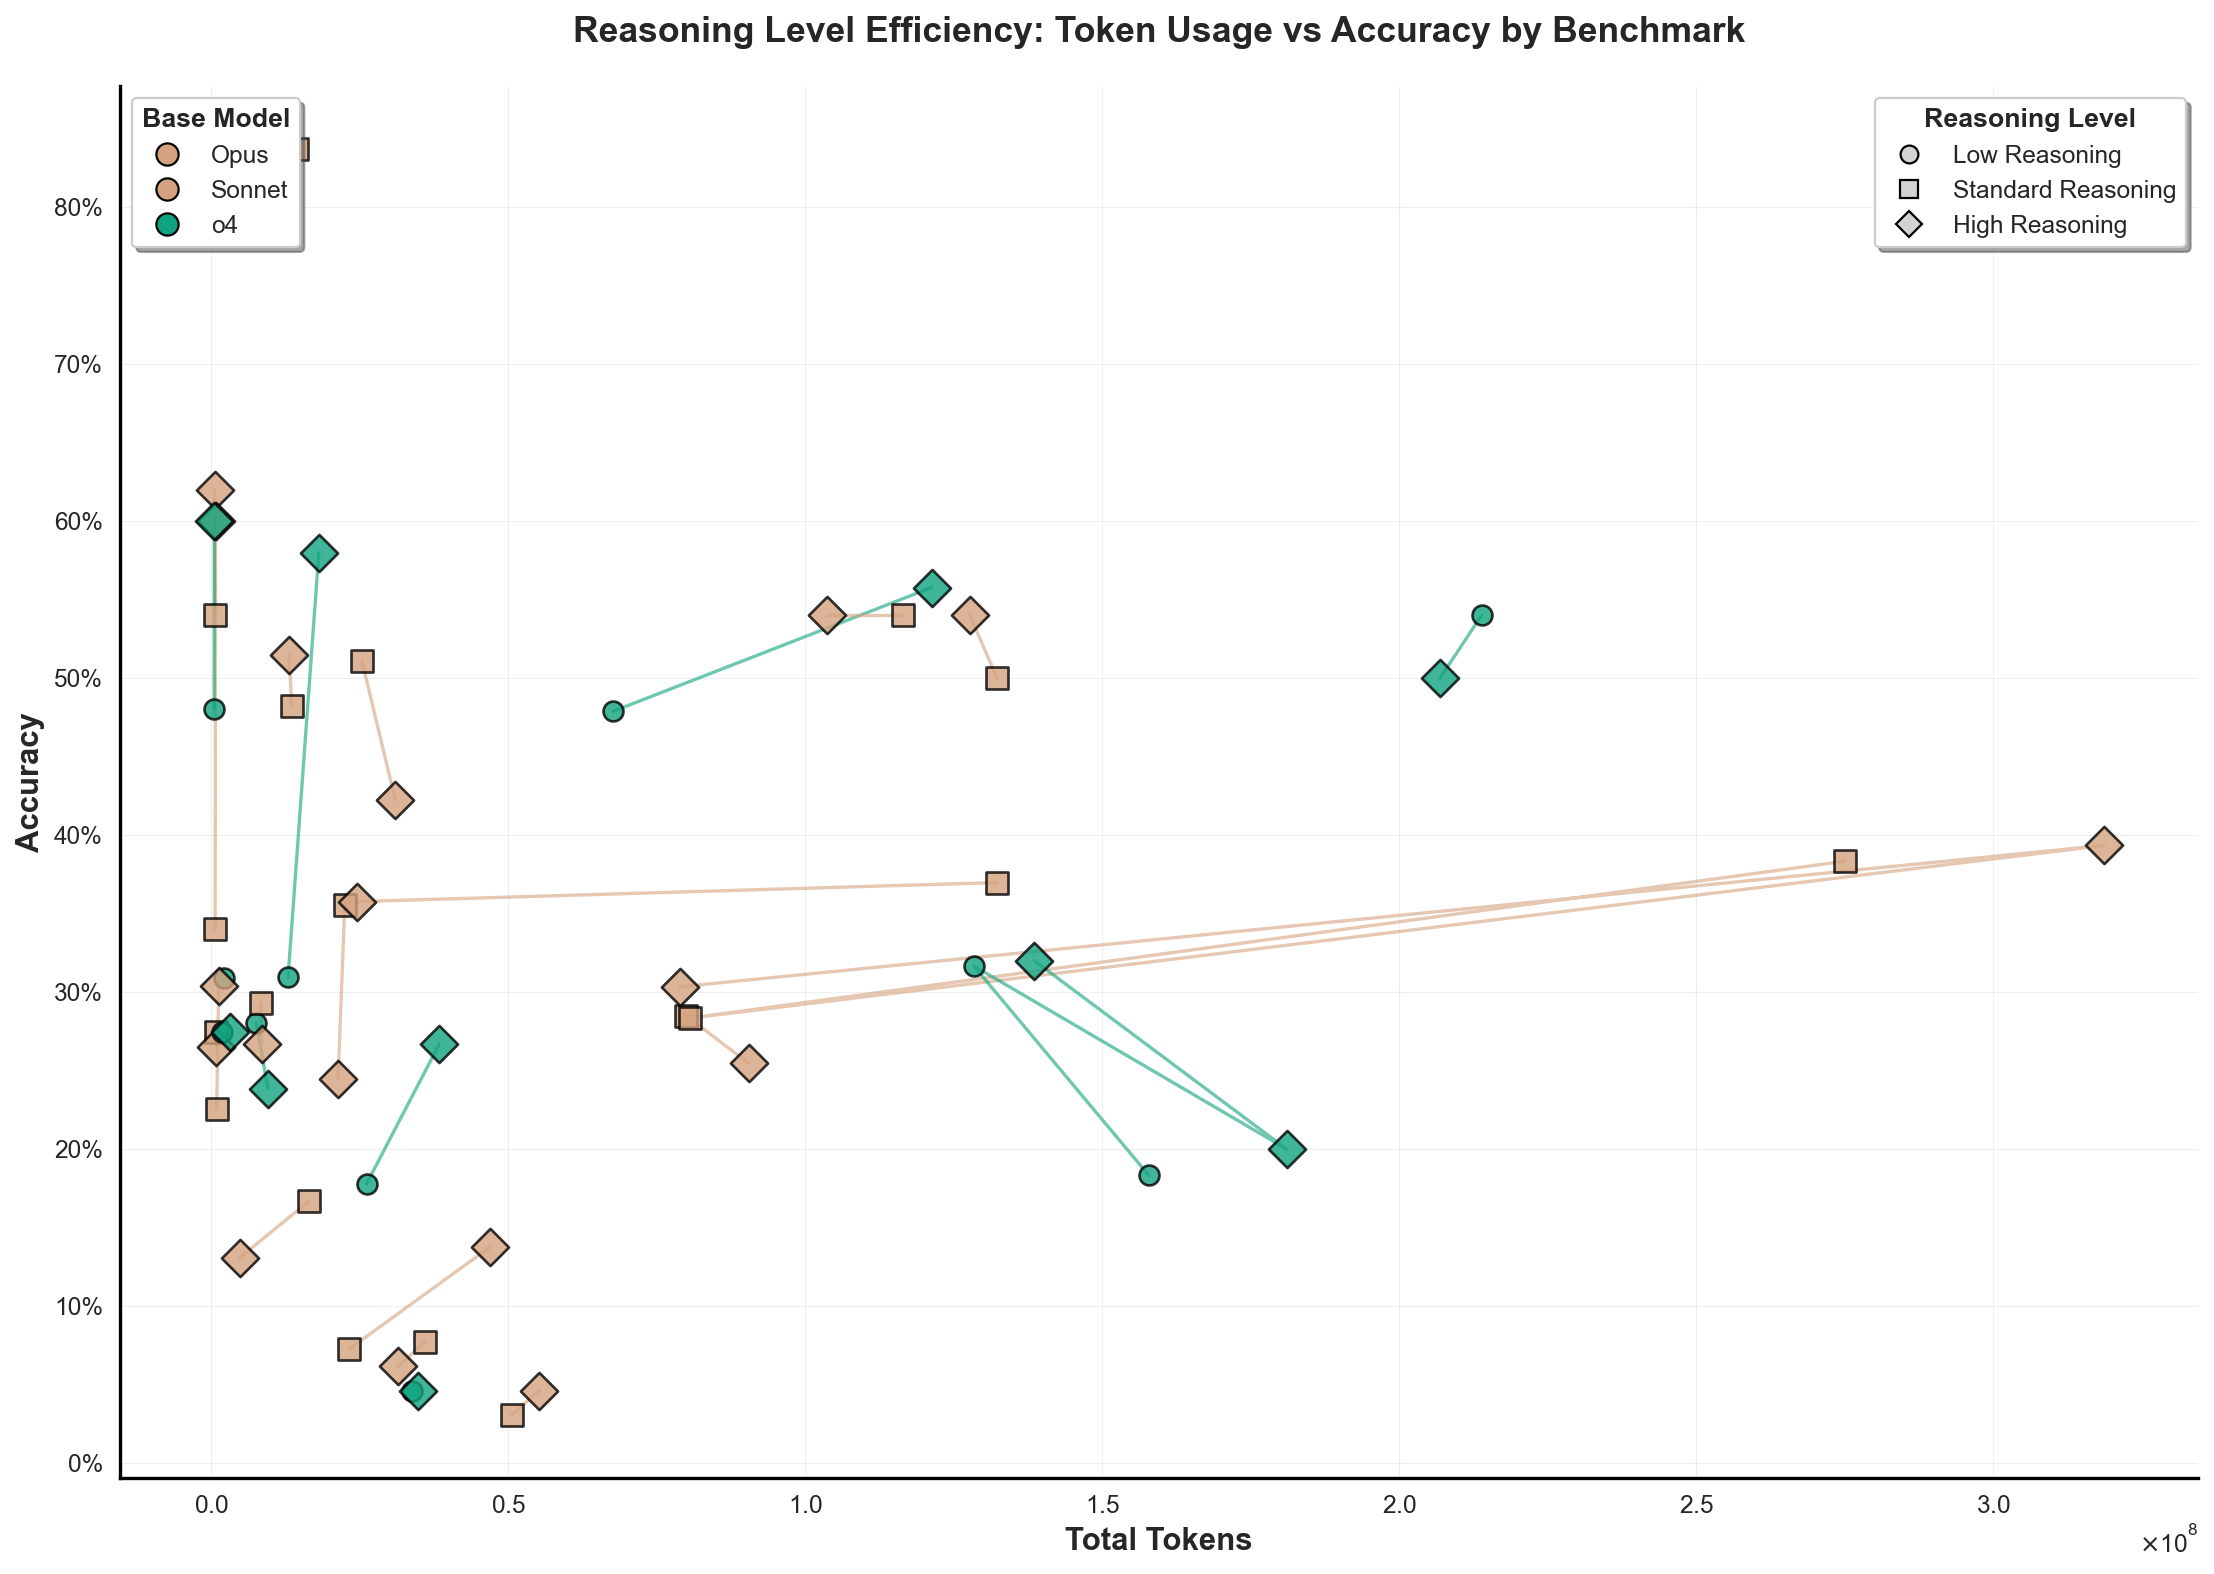

Saved plot: reasoning_level_efficiency_scatter.png

Reasoning Level Efficiency Summary:

Opus:
  High: 35.2% accuracy, 39,712,922 avg tokens, 0.009 accuracy per M tokens
  Standard: 34.8% accuracy, 36,954,646 avg tokens, 0.009 accuracy per M tokens

Sonnet:
  High: 31.9% accuracy, 64,123,824 avg tokens, 0.005 accuracy per M tokens
  Standard: 34.4% accuracy, 66,722,405 avg tokens, 0.005 accuracy per M tokens

o4:
  High: 40.1% accuracy, 68,710,924 avg tokens, 0.006 accuracy per M tokens
  Low: 35.0% accuracy, 54,494,290 avg tokens, 0.006 accuracy per M tokens


In [ ]:
# ═══════════════════════════════════════════════════════════════════
# REASONING LEVEL EFFICIENCY SCATTER PLOT
# ═══════════════════════════════════════════════════════════════════

def plot_reasoning_level_efficiency(df, save_plots=False):
    """
    Create a scatter plot showing token usage vs accuracy for reasoning level models,
    with lines connecting each pair for each benchmark.
    """
    plt.close('all')
    
    # Set up the plot style
    mpl.rcParams.update({
        "figure.dpi": 160,
        "savefig.dpi": 300,
        "font.size": 12,
        "hatch.linewidth": .8,
        "font.family": "Inter",
        "font.weight": 400,
    })
    sns.set_theme(style="white", rc={"axes.grid": False})
    
    # Filter to models containing o4, Sonnet, or Opus with token data
    reasoning_models = df[
        df['model'].str.contains('o4|Sonnet|Opus', case=False, na=False) &
        df['total_tokens'].notna() &
        df['accuracy'].notna()
    ].copy()
    
    if reasoning_models.empty:
        print("No reasoning models found with token data.")
        return
    
    # Extract base model name and reasoning level
    def extract_model_info(model_name):
        """Extract base model and reasoning level from model name."""
        model_name = str(model_name)
        
        if 'o4' in model_name.lower():
            if 'high' in model_name.lower():
                return 'o4', 'High'
            elif 'low' in model_name.lower():
                return 'o4', 'Low'
            else:
                return 'o4', 'Medium'
        elif 'sonnet' in model_name.lower():
            if 'high' in model_name.lower():
                return 'Sonnet', 'High'
            else:
                return 'Sonnet', 'Standard'
        elif 'opus' in model_name.lower():
            if 'high' in model_name.lower():
                return 'Opus', 'High'
            else:
                return 'Opus', 'Standard'
        
        return None, None
    
    # Extract model info
    reasoning_models[['base_model', 'reasoning_level']] = reasoning_models['model'].apply(
        lambda x: pd.Series(extract_model_info(x))
    )
    
    # Filter out any models where we couldn't extract info
    reasoning_models = reasoning_models.dropna(subset=['base_model', 'reasoning_level'])
    
    # Check which base models have multiple reasoning levels
    level_counts = reasoning_models.groupby('base_model')['reasoning_level'].nunique()
    multi_level_models = level_counts[level_counts > 1].index.tolist()
    
    if not multi_level_models:
        print("No models found with multiple reasoning levels.")
        return
    
    # Filter to only multi-level models
    plot_data = reasoning_models[
        reasoning_models['base_model'].isin(multi_level_models)
    ].copy()
    
    # Set up colors for base models
    base_model_colors = {}
    for bm in multi_level_models:
        if 'o4' in bm.lower():
            base_model_colors[bm] = BRAND_BASE.get("OpenAI", "#10A37F")
        elif 'sonnet' in bm.lower():
            base_model_colors[bm] = BRAND_BASE.get("Anthropic", "#D4A27F")
        elif 'opus' in bm.lower():
            base_model_colors[bm] = BRAND_BASE.get("Anthropic", "#D4A27F")
        else:
            base_model_colors[bm] = "#777777"
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Marker styles for reasoning levels
    level_markers = {'Low': 'o', 'Standard': 's', 'Medium': '^', 'High': 'D'}
    level_sizes = {'Low': 80, 'Standard': 100, 'Medium': 120, 'High': 140}
    
    # Plot points and connecting lines for each benchmark
    for benchmark in plot_data['benchmark_name'].unique():
        benchmark_data = plot_data[plot_data['benchmark_name'] == benchmark]
        
        # Group by base model within this benchmark
        for base_model in multi_level_models:
            model_data = benchmark_data[benchmark_data['base_model'] == base_model]
            
            if len(model_data) > 1:  # Only draw lines if we have multiple levels
                # Sort by reasoning level for consistent line drawing
                level_order = ['Low', 'Standard', 'Medium', 'High']
                model_data = model_data.sort_values('reasoning_level', key=lambda x: x.map({l: i for i, l in enumerate(level_order)}))
                
                # Draw connecting line
                ax.plot(
                    model_data['total_tokens'], 
                    model_data['accuracy'],
                    color=base_model_colors[base_model],
                    linewidth=1.5,
                    alpha=0.6,
                    zorder=1
                )
            
            # Plot individual points
            for _, row in model_data.iterrows():
                ax.scatter(
                    row['total_tokens'],
                    row['accuracy'],
                    color=base_model_colors[base_model],
                    s=level_sizes.get(row['reasoning_level'], 100),
                    marker=level_markers.get(row['reasoning_level'], 'o'),
                    edgecolor='black',
                    linewidth=1.2,
                    alpha=0.8,
                    zorder=3
                )
    
    # Create legend
    # Legend for base models (colors)
    color_legend_elements = []
    for base_model in sorted(multi_level_models):
        color_legend_elements.append(
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=base_model_colors[base_model],
                      markersize=10, markeredgecolor='black', label=base_model)
        )
    
    # Legend for reasoning levels (markers)
    marker_legend_elements = []
    used_levels = set(plot_data['reasoning_level'].unique())
    for level in ['Low', 'Standard', 'Medium', 'High']:
        if level in used_levels:
            marker_legend_elements.append(
                plt.Line2D([0], [0], marker=level_markers[level], color='w', 
                          markerfacecolor='lightgray', markersize=8, 
                          markeredgecolor='black', label=f'{level} Reasoning')
            )
    
    # Add legends
    if color_legend_elements:
        legend1 = ax.legend(handles=color_legend_elements, loc='upper left', 
                           title='Base Model', frameon=True, fancybox=True, shadow=True)
        legend1.get_title().set_fontweight('bold')
        ax.add_artist(legend1)
    
    if marker_legend_elements:
        legend2 = ax.legend(handles=marker_legend_elements, loc='upper right', 
                           title='Reasoning Level', frameon=True, fancybox=True, shadow=True)
        legend2.get_title().set_fontweight('bold')
    
    # Style the plot
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    for spine in ('left', 'bottom'):
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_linewidth(1.5)
        ax.spines[spine].set_color('black')
    
    ax.tick_params(axis='both', which='major', color='black', width=1, length=4)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=1)
    
    # Set labels and title
    ax.set_xlabel('Total Tokens', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
    ax.set_title('Reasoning Level Efficiency: Token Usage vs Accuracy by Benchmark', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Format axes
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
    ax.xaxis.major.formatter._useMathText = True
    
    # Add some padding to the axis limits
    x_margin = (plot_data['total_tokens'].max() - plot_data['total_tokens'].min()) * 0.05
    y_margin = (plot_data['accuracy'].max() - plot_data['accuracy'].min()) * 0.05
    ax.set_xlim(plot_data['total_tokens'].min() - x_margin, plot_data['total_tokens'].max() + x_margin)
    ax.set_ylim(plot_data['accuracy'].min() - y_margin, plot_data['accuracy'].max() + y_margin)
    
    plt.tight_layout()
    plt.show()
    
    # Save plot if requested
    if save_plots:
        output_path = str(quantitative_dir / "plots/")
        output_filename = "reasoning_level_efficiency_scatter.png"
        fig.savefig(os.path.join(output_path, output_filename), bbox_inches='tight', dpi=300)
        print(f"Saved plot: {output_filename}")
    
    # Print summary statistics
    print(f"\nReasoning Level Efficiency Summary:")
    for base_model in sorted(multi_level_models):
        print(f"\n{base_model}:")
        model_data = plot_data[plot_data['base_model'] == base_model]
        level_stats = model_data.groupby('reasoning_level').agg({
            'total_tokens': 'mean',
            'accuracy': 'mean'
        }).round(3)
        
        for level, stats in level_stats.iterrows():
            efficiency = stats['accuracy'] / (stats['total_tokens'] / 1e6)  # Accuracy per million tokens
            print(f"  {level}: {stats['accuracy']:.1%} accuracy, {stats['total_tokens']:,.0f} avg tokens, "
                  f"{efficiency:.3f} accuracy per M tokens")

# Create the reasoning level efficiency scatter plot
print("Creating reasoning level efficiency scatter plot...")
plot_reasoning_level_efficiency(filtered_df, save_plots=True)

Does more reasoning use more tokens?
Median % increase per adjacent step: 33.1%
Sign test: 9/10 positive (p = 0.0107); Wilcoxon p = 0.00293

Median % increase by step:
  Low→High: 33.1%


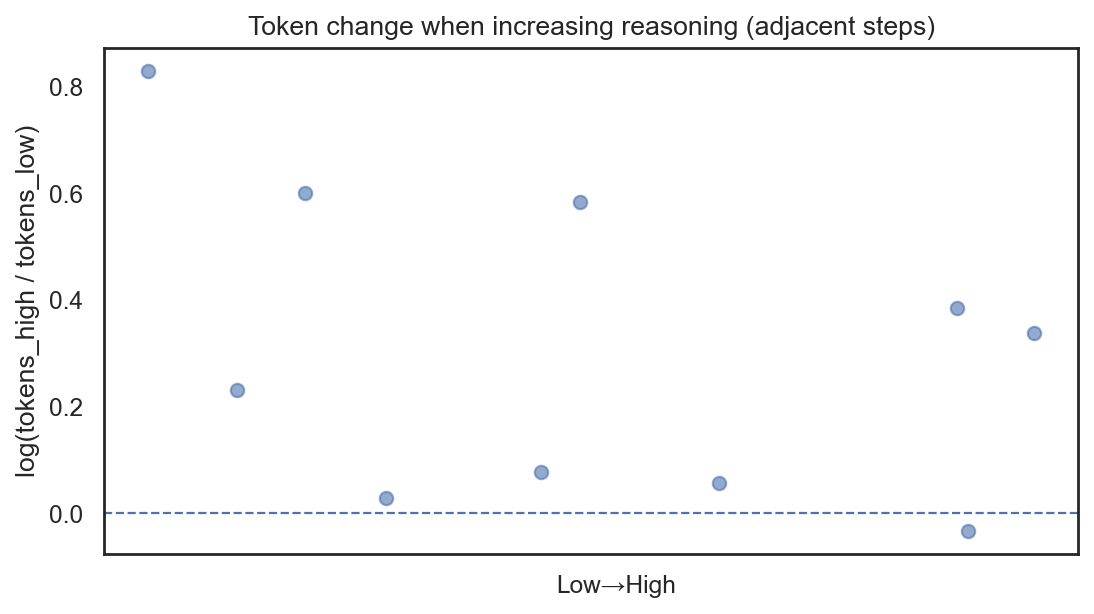

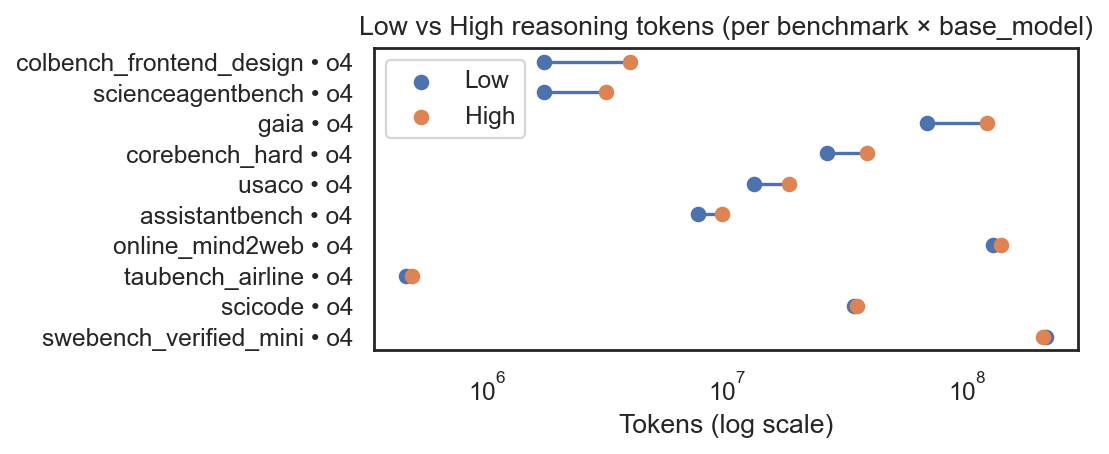

,benchmark_name,base_model,from_level,to_level,step,log_ratio,pct_change,tokens_low,tokens_high
0,assistantbench,o4,Low,High,Low→High,0.231624,0.260646,7548280.0,9515708.0
1,colbench_frontend_design,o4,Low,High,Low→High,0.829804,1.292870,1718154.0,3939503.0
2,corebench_hard,o4,Low,High,Low→High,0.384094,0.468284,26106346.0,38331520.0
3,gaia,o4,Low,High,Low→High,0.583572,0.792429,67629332.0,121220792.0
4,online_mind2web,o4,Low,High,Low→High,0.076459,0.079458,128308906.0,138504024.0
5,scicode,o4,Low,High,Low→High,0.028499,0.028909,33787461.0,34764227.0
6,scienceagentbench,o4,Low,High,Low→High,0.600608,0.823227,1715012.0,3126856.0
7,swebench_verified_mini,o4,Low,High,Low→High,-0.033210,-0.032664,213838734.0,206853860.0
8,taubench_airline,o4,Low,High,Low→High,0.056305,0.057920,457562.0,484064.0
9,usaco,o4,Low,High,Low→High,0.337586,0.401559,12898464.0,18077964.0


In [ ]:
import numpy as np, pandas as pd
from scipy.stats import binomtest, wilcoxon
import matplotlib.pyplot as plt

LEVEL_ORDER = ['Low','Standard','Medium','High']
LEVEL_RANK = {lvl:i for i,lvl in enumerate(LEVEL_ORDER)}

def extract_base_and_level(model_name):
    m = str(model_name).lower()
    if 'o4' in m: base = 'o4'
    elif 'sonnet' in m: base = 'Sonnet'
    elif 'opus' in m: base = 'Opus'
    else: base = 'Other'
    if   'high' in m: lvl = 'High'
    elif 'medium' in m: lvl = 'Medium'
    elif 'low' in m: lvl = 'Low'
    elif 'standard' in m: lvl = 'Standard'
    else: lvl = None
    return base, lvl

def build_reasoning_pairs(df):
    d = df.dropna(subset=['benchmark_name','model','total_tokens']).copy()
    d['base_model'], d['reasoning_level'] = zip(*d['model'].map(extract_base_and_level))
    d = d.dropna(subset=['reasoning_level'])
    # choose token metric
    token_col = 'tokens_per_task' if 'tokens_per_task' in d.columns else 'total_tokens'
    d = d[d[token_col] > 0].copy()
    d['log_tokens'] = np.log(d[token_col])

    rows = []
    for (b, bm), g in d.groupby(['benchmark_name','base_model']):
        # keep best (min) tokens per level if duplicates exist
        gg = g.sort_values(['reasoning_level', 'log_tokens'])
        gg = gg.groupby('reasoning_level', as_index=False).first()
        gg = gg[gg['reasoning_level'].isin(LEVEL_ORDER)].copy()
        if gg.empty: 
            continue
        gg['rank'] = gg['reasoning_level'].map(LEVEL_RANK)
        gg = gg.sort_values('rank')
        # adjacent steps only
        for i in range(len(gg)-1):
            lo = gg.iloc[i]
            hi = gg.iloc[i+1]
            step = f"{lo['reasoning_level']}→{hi['reasoning_level']}"
            log_ratio = hi['log_tokens'] - lo['log_tokens']
            pct_change = np.exp(log_ratio) - 1.0
            rows.append({
                'benchmark_name': b,
                'base_model': bm,
                'from_level': lo['reasoning_level'],
                'to_level': hi['reasoning_level'],
                'step': step,
                'log_ratio': log_ratio,
                'pct_change': pct_change,
                'tokens_low': np.exp(lo['log_tokens']),
                'tokens_high': np.exp(hi['log_tokens'])
            })
    return pd.DataFrame(rows)

pairs = build_reasoning_pairs(filtered_df)
if pairs.empty:
    print("No comparable pairs found."); 
else:
    # Overall summary
    med_pct = 100*pairs['pct_change'].median()
    pos = np.sum(pairs['log_ratio'] > 0)
    neg = np.sum(pairs['log_ratio'] < 0)
    n_eff = pos + neg
    p_sign = binomtest(pos, n_eff, p=0.5, alternative='greater').pvalue if n_eff>0 else np.nan
    try:
        p_wilcox = wilcoxon(pairs['log_ratio'], alternative='greater').pvalue
    except ValueError:
        p_wilcox = np.nan

    print(f"Does more reasoning use more tokens?")
    print(f"Median % increase per adjacent step: {med_pct:.1f}%")
    print(f"Sign test: {pos}/{n_eff} positive (p = {p_sign:.3g}); Wilcoxon p = {p_wilcox:.3g}")

    # Per-step breakdown
    step_med = pairs.groupby('step')['pct_change'].median().sort_values()
    print("\nMedian % increase by step:")
    for step, v in step_med.items():
        print(f"  {step}: {100*v:.1f}%")

    # Figure A: distribution of log-ratios by step
    plt.figure(figsize=(7,4))
    # simple beeswarm-ish jitter with matplotlib (no seaborn dependency)
    xcats = sorted(pairs['step'].unique(), key=lambda s: [LEVEL_RANK[s.split('→')[0]], LEVEL_RANK[s.split('→')[1]]])
    xpos = {c:i for i,c in enumerate(xcats)}
    x = np.array([xpos[c] for c in pairs['step']])
    jitter = (np.random.rand(len(x))-0.5)*0.25
    plt.axhline(0, linewidth=1, linestyle='--')
    plt.scatter(x + jitter, pairs['log_ratio'], alpha=0.6)
    plt.xticks(range(len(xcats)), xcats, rotation=0)
    plt.ylabel('log(tokens_high / tokens_low)')
    plt.title('Token change when increasing reasoning (adjacent steps)')
    plt.tight_layout()
    plt.show()

    # Figure B (optional): dumbbell Low vs High per cell
    # Build Low vs High direct pairs for a quicker gestalt
    def low_high_pairs(df):
        d = df.dropna(subset=['benchmark_name','model','total_tokens']).copy()
        d['base_model'], d['level'] = zip(*d['model'].map(extract_base_and_level))
        token_col = 'tokens_per_task' if 'tokens_per_task' in d.columns else 'total_tokens'
        d = d[d[token_col]>0]
        out = []
        for (b,bm), g in d.groupby(['benchmark_name','base_model']):
            if {'Low','High'}.issubset(set(g['level'])):
                lo = g[g['level']=='Low'].sort_values(token_col).iloc[0]
                hi = g[g['level']=='High'].sort_values(token_col).iloc[0]
                out.append({
                    'label': f"{b} • {bm}",
                    'low': lo[token_col],
                    'high': hi[token_col],
                    'log_ratio': np.log(hi[token_col]/lo[token_col])
                })
        return pd.DataFrame(out)

    lh = low_high_pairs(filtered_df)
    if not lh.empty:
        lh = lh.sort_values('log_ratio')
        plt.figure(figsize=(7, max(3, 0.25*len(lh))))
        y = np.arange(len(lh))
        plt.hlines(y, lh['low'], lh['high'])
        plt.scatter(lh['low'], y, label='Low', zorder=3)
        plt.scatter(lh['high'], y, label='High', zorder=3)
        plt.xscale('log')
        plt.yticks(y, lh['label'])
        plt.xlabel('Tokens (log scale)')
        plt.title('Low vs High reasoning tokens (per benchmark × base_model)')
        plt.legend()
        plt.tight_layout(); plt.show()

build_reasoning_pairs(filtered_df)